In [ ]:
import sys
!git clone https://github.com/diman199888/quantitative-finance.git
sys.path.append("/content/quantitative-finance/crypto-arbitrage-model/")

import crypto_arb_utils as cc

import importlib
importlib.reload(cc)

from sqlalchemy import create_engine
import sqlite3
import psycopg2

import pandas as pd
import numpy as np
import polars as pl

import time
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import logging

import statsmodels.api as sm

from tqdm import tqdm


pd.set_option('display.max_columns',  None)
#pd.set_option('display.max_rows', 250)
#pd.set_option('display.float_format', '{:.5f}'.format)
from IPython.display import display


import sklearn
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, RidgeClassifier, SGDClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, zero_one_loss, make_scorer, accuracy_score, f1_score, precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
!pip install optuna
import optuna


import joblib

fatal: destination path 'quantitative-finance' already exists and is not an empty directory.


In [ ]:
#setup the logging module
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s", force=True)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Preprocess collected data

In [ ]:
database_path_in_drive = '/content/drive/My Drive/Databases/crypto.db'
engine = create_engine(f"sqlite:///{database_path_in_drive}")  #the data from postgresql was transfered to sqlite due to Colab's pecularities
df = cc.download_data(engine)
df

2025-05-23 17:49:08,292 - INFO - Connecting to database…
2025-05-23 17:50:35,750 - INFO - Data loaded
2025-05-23 17:51:24,924 - INFO - Loaded rows:26,390,595
Time elapsed:136.63 s


exchange,ts,side,level1_price,level1_size,level2_price,level2_size,level3_price,level3_size
str,i64,str,f64,f64,f64,f64,f64,f64
"""Bybit""",1744811324776,"""bid""",74.06,68.30026,74.05,93.52903,74.04,156.80797
"""Bybit""",1744811324776,"""ask""",74.08,16.93638,74.09,48.66282,74.1,47.20968
"""Bybit""",1744811324896,"""bid""",74.06,68.30026,74.05,100.28442,74.04,156.80797
"""Bybit""",1744811324976,"""bid""",74.06,71.67544,74.05,100.28442,74.04,156.80797
"""Bybit""",1744811325196,"""bid""",74.07,8.1,74.06,71.67544,74.05,100.28442
…,…,…,…,…,…,…,…,…
"""Bybit""",1746643832136,"""ask""",87.94,0.17196,87.95,85.63987,87.96,94.85292
"""HTX""",1746643832109,"""ask""",87.93,21.8137,87.94,3.24,87.95,20.14
"""Bybit""",1746643832176,"""ask""",87.94,0.17196,87.95,89.67909,87.96,94.85292


In [ ]:
exchange1 = "HTX"
exchange2 = "Bybit"

In [ ]:
df_exchange1 = cc.get_orderbook_snapshot(df, exchange1)
df_exchange2 = cc.get_orderbook_snapshot(df, exchange2)

2025-05-23 17:51:28,131 - INFO - DataFrame for HTX processed. Number of rows:
9,737,563
2025-05-23 17:51:32,415 - INFO - DataFrame for Bybit processed. Number of rows:
12,108,887


In [ ]:
df_merged = cc.merge_data(df_exchange1, exchange1, df_exchange2, exchange2)
df_merged

2025-05-23 17:51:46,378 - INFO - DataFrames for HTX and Bybit processed. 
Number of rows: 21,637,878


ts,HTX_level1_price_bid,HTX_level1_size_bid,HTX_level2_price_bid,HTX_level2_size_bid,HTX_level3_price_bid,HTX_level3_size_bid,HTX_level1_price_ask,HTX_level1_size_ask,HTX_level2_price_ask,HTX_level2_size_ask,HTX_level3_price_ask,HTX_level3_size_ask,HTX_delta_ts,Bybit_level1_price_bid,Bybit_level1_size_bid,Bybit_level2_price_bid,Bybit_level2_size_bid,Bybit_level3_price_bid,Bybit_level3_size_bid,Bybit_level1_price_ask,Bybit_level1_size_ask,Bybit_level2_price_ask,Bybit_level2_size_ask,Bybit_level3_price_ask,Bybit_level3_size_ask,Bybit_delta_ts,timedelta
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
1744811325304,74.07,4.86,74.06,6.6699,74.05,9.72,74.08,4.86,74.09,4.86,74.12,4.86,28,74.07,13.48915,74.06,93.78829,74.05,145.46272,74.08,0.37586,74.09,13.76403,74.1,32.88344,28,28
1744811325336,74.07,4.86,74.06,6.6699,74.05,9.72,74.08,4.86,74.09,4.86,74.12,4.86,32,74.07,20.23905,74.06,85.77832,74.05,145.46272,74.08,0.37586,74.09,8.62298,74.1,32.88344,60,-32
1744811325356,74.07,4.86,74.06,6.6699,74.05,9.72,74.08,4.86,74.09,4.86,74.12,4.86,52,74.07,20.23905,74.06,121.54773,74.05,145.46272,74.08,0.37586,74.09,8.62298,74.1,32.88344,20,-52
1744811325416,74.07,4.86,74.06,6.6699,74.05,9.72,74.08,4.86,74.09,4.86,74.12,4.86,112,74.07,23.614,74.06,121.54773,74.05,142.08686,74.08,0.37586,74.09,8.62298,74.1,32.88344,60,-112
1744811325436,74.07,4.86,74.06,6.6699,74.05,9.72,74.08,4.86,74.09,4.86,74.12,4.86,132,74.07,34.86054,74.06,121.54773,74.05,152.56376,74.08,0.37586,74.09,8.62298,74.1,41.33886,20,-132
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1746643832117,87.91,6.48,87.9,23.85,87.89,21.24,87.93,21.8137,87.94,3.24,87.95,20.14,8,87.93,16.76849,87.92,37.4852,87.91,37.59036,87.94,0.17196,87.95,85.63987,87.96,90.64008,21,-8
1746643832136,87.91,6.48,87.9,23.85,87.89,21.24,87.93,21.8137,87.94,3.24,87.95,20.14,27,87.93,16.76849,87.92,37.4852,87.91,42.41956,87.94,0.17196,87.95,85.63987,87.96,94.85292,19,-27
1746643832176,87.91,6.48,87.9,23.85,87.89,21.24,87.93,21.8137,87.94,3.24,87.95,20.14,67,87.93,16.76849,87.92,37.4852,87.91,42.41956,87.94,0.17196,87.95,89.67909,87.96,94.85292,40,-67


In [ ]:
df_strategy = cc.strategy(df_merged, exchange1, exchange2)

2025-05-23 17:51:46,955 - INFO - DataFrame processed. Number of active arbitrage window rows        
For strategy 'buy at HTX, sell at Bybit':         8,733,160         
For strategy 'buy at Bybit, sell at HTX':         518,320


In [ ]:
df_n = cc.duration_calculation(df_strategy)

2025-05-23 17:51:50,388 - INFO - DataFrame processed.                 
Number of arbitrages: 94,396                


In [ ]:
df_train = cc.feature_selection(df_n, exchange1, exchange2, roll = '1m')
arbitrage_model = cc.final_manipulations(df_train, include_first_observation = False, n_lags = 5)

2025-05-23 17:52:15,969 - INFO - DataFrame processed. Number of excluded observations: 31                
Excluded id`s: {0, 1, 19484, 19485, 29342, 29343, 29344, 29345, 29346, 29347, 29348, 29349, 29350, 29351, 19112, 19113, 29354, 29355, 29352, 29357, 29353, 29356, 49986, 49987, 29513, 29514, 29341, 19426, 19427, 27635, 27636}                
Average arbitrage duration:  1654


In [ ]:
#arbitrage_model.write_parquet('/content/drive/MyDrive/arbitrage_model.parquet') #save the preprocessed data
arbitrage_model

# 2. Modelling

## Preparation

upload data:

In [ ]:
arbitrage_model = pl.read_parquet('/content/drive/MyDrive/arbitrage_model.parquet')
arbitrage_model = arbitrage_model.to_pandas()

define accuracy metrics:

In [ ]:
def matrix(y_test, y_pred):
  print(classification_report(y_test, y_pred))
  cm = confusion_matrix(y_pred, y_test, labels=[0,1])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["<550ms","≥550ms"])
  disp.plot(cmap=plt.cm.Blues)
  plt.title("Confusion Matrix")
  plt.show()
  return cm

def accuracy(y_test, y_pred):
  print(f'share of 0`s in the dataset: {y_test[y_test == 0].shape[0] / y_test.shape[0]: .1%}\n')
  print(f'accuracy: {accuracy_score(y_test, y_pred): .1%}\n')

split and scale the data:

In [ ]:
X = arbitrage_model.drop(columns = ['ts', 'length', 'dummy', 'arbitrage_id'])
y = arbitrage_model["dummy"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, '/content/drive/MyDrive/scaler.pkl')

['/content/drive/MyDrive/scaler.pkl']

bonus: time-series split

In [ ]:
"""
tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train_ts, X_test_ts = X.iloc[train_index], X.iloc[test_index]
    y_train_ts, y_test_ts = y.iloc[train_index], y.iloc[test_index]

scaler = StandardScaler()
X_train_ts_scaled = scaler.fit_transform(X_train_ts)
X_test_ts_scaled = scaler.transform(X_test_ts)
"""

'\ntscv = TimeSeriesSplit()\n\nfor train_index, test_index in tscv.split(X):\n    X_train_ts, X_test_ts = X.iloc[train_index], X.iloc[test_index]\n    y_train_ts, y_test_ts = y.iloc[train_index], y.iloc[test_index]\n\nscaler = StandardScaler()\nX_train_ts_scaled = scaler.fit_transform(X_train_ts)\nX_test_ts_scaled = scaler.transform(X_test_ts)\n'

## Linear Models

#### Logistic Regression:

share of 0`s in the dataset:  64.0%

accuracy:  63.4%

              precision    recall  f1-score   support

           0       0.76      0.62      0.68      8914
           1       0.49      0.66      0.56      5006

    accuracy                           0.63     13920
   macro avg       0.63      0.64      0.62     13920
weighted avg       0.67      0.63      0.64     13920



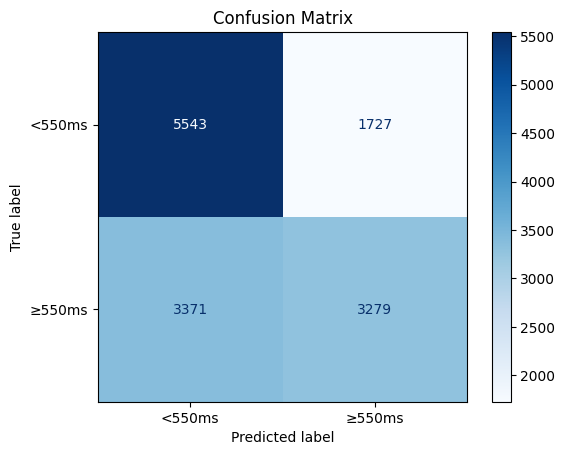

['/content/drive/MyDrive/logit.pkl']

In [ ]:
best_params_logistic = {'C': 1, 'fit_intercept': True, 'intercept_scaling': 1, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.001} #parameters selected by gridsearch
logistic = LogisticRegression(**best_params_logistic, class_weight='balanced', max_iter=100000).fit(X_train_scaled, y_train)

# evaluate on test set
y_pred_logistic  = logistic.predict(X_test_scaled)
# assess accuracy of the model
accuracy(y_test, y_pred_logistic)
# show confussion matrix
cm1 = matrix(y_test, y_pred_logistic)
# save the model
joblib.dump(logistic, '/content/drive/MyDrive/logit.pkl')

Apparently, the goal is to create a model that would beat the naive approach of assigning 0 to the whole dataset

#### Ridge Classifier:

share of 0`s in the dataset:  64.0%

accuracy:  64.1%

              precision    recall  f1-score   support

           0       0.77      0.63      0.69      8914
           1       0.50      0.67      0.57      5006

    accuracy                           0.64     13920
   macro avg       0.63      0.65      0.63     13920
weighted avg       0.67      0.64      0.65     13920



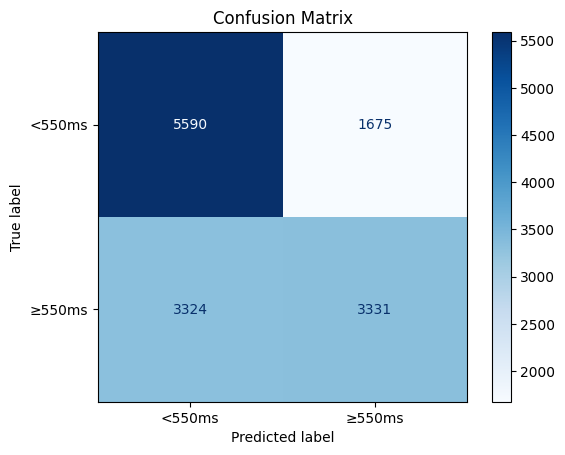

In [ ]:
#best_params_ridge = {'positive': False, 'alpha': 36.79070474310095, 'solver': 'cholesky', 'tol': 0.008059696745044236}  ##Optuna choice; slightly poorer performance
best_params_ridge = {'alpha': 1.0, 'positive': False, 'solver': 'svd', 'tol': 0.0001} #gridsearch

ridge_model = RidgeClassifier(**best_params_ridge, class_weight='balanced', random_state=42).fit(X_train_scaled, y_train)

# evaluate on test set
y_pred_final_ridge = ridge_model.predict(X_test_scaled)
# assess accuracy of the model
accuracy(y_test, y_pred_final_ridge)
# show confussion matrix
cm1 = matrix(y_test, y_pred_final_ridge)

#### SGD Classifier:

share of 0`s in the dataset:  64.0%

accuracy:  59.2%

              precision    recall  f1-score   support

           0       0.79      0.49      0.61      8914
           1       0.46      0.77      0.58      5006

    accuracy                           0.59     13920
   macro avg       0.63      0.63      0.59     13920
weighted avg       0.67      0.59      0.60     13920



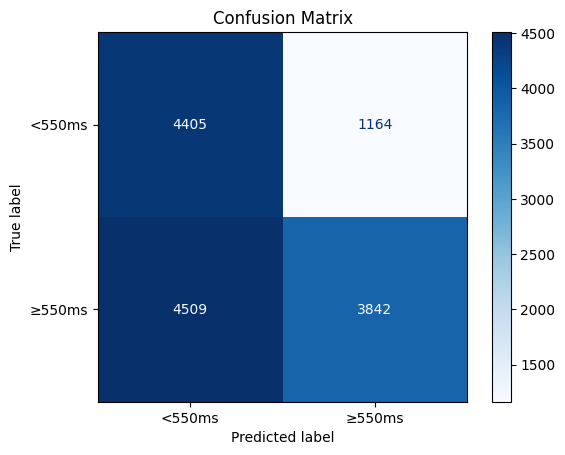

In [ ]:
best_params_sgd = {'loss': 'squared_hinge', 'penalty': None, 'alpha': 11.36025619228003,
               'l1_ratio': 0.23656417101535032, 'fit_intercept': False, 'tol': 9.645686618277331,
               'shuffle': True, 'learning_rate': 'adaptive', 'power_t': -9.272030937687902,
               'early_stopping': False, 'average': True, 'eta0': 5.452631621414764}  #as selected by optuna

sgd_model = SGDClassifier(**best_params_sgd, class_weight='balanced', random_state=42, n_jobs=-1, max_iter = 100000).fit(X_train_scaled, y_train)

# evaluate on test set
y_pred_sgd = sgd_model.predict(X_test_scaled)
# assess accuracy of the model
accuracy(y_test, y_pred_sgd)
# show confussion matrix
cm1 = matrix(y_test, y_pred_sgd)

#### Passive Agressive Classifier:

share of 0`s in the dataset:  64.0%

accuracy:  61.3%

              precision    recall  f1-score   support

           0       0.77      0.57      0.65      8914
           1       0.47      0.70      0.57      5006

    accuracy                           0.61     13920
   macro avg       0.62      0.63      0.61     13920
weighted avg       0.66      0.61      0.62     13920



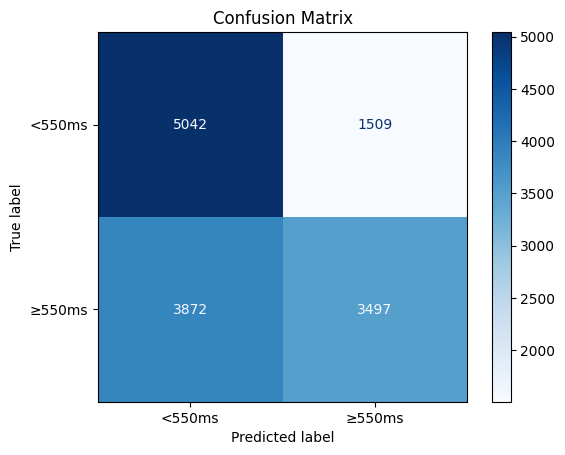

In [ ]:
best_params_pac = {'loss': 'hinge',
 'C': 0.00016275314358328043,
 'fit_intercept': False,
 'tol': 0.0031308644232425752}

# Train the model
pac_model = PassiveAggressiveClassifier(**best_params_pac, class_weight='balanced', max_iter=100000, random_state=42, n_jobs=-1).fit(X_train_scaled, y_train)
# evaluate on test set
y_pred_pac = pac_model.predict(X_test_scaled)
# assess accuracy of the model
accuracy(y_test, y_pred_pac)
# show confussion matrix
cm1 = matrix(y_test, y_pred_pac)

## CUML: Support Vector Machine & Random Forest

#### SVM:

Start with sklearn's SVM:

In [ ]:
%%time
svm = SVC().fit(X_train_scaled, y_train)

# evaluate on test set
y_pred_svm  = svm.predict(X_test_scaled)
# assess accuracy of the model
accuracy(y_test, y_pred_svm)
# show confussion matrix
cm_svm = matrix(y_test, y_pred_svm)

Since CPU computing is cumbersome, we can take advantage of Colab's GPU

In [ ]:
!nvidia-smi

Fri May 23 17:16:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   39C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
Installing RAPIDS remaining 25.04 libraries
Using Python 3.11.12 environment at: /usr
Audited 11 packages in 171ms

        ***********************************************************************
        The pip install of RAPIDS is complete.

        Please do not run any further installation from the conda based installation methods, as they may cause issues!

        Please ensure that you're pulling from the git repo to remain updated with the latest working install scripts.

        Troubleshooting:
            - If there is an installation failure, please check back on RAPIDSAI owned templates/notebooks to see how to update your personal files.
            - If an installation failure persists when using the latest script, please make an issue on https://github.com/rapidsai-community/rapidsai-csp-utils
        ***********************************************************************
        


In [ ]:
from cuml.svm import SVC as cuML_SVC
from cuml.svm import LinearSVC
from cuml.ensemble import RandomForestClassifier as cuRFC

import cudf
import cupy as cp

In [ ]:
X_train_cudf = cudf.DataFrame.from_pandas(X_train)
y_train_cudf = cudf.Series(y_train)

X_test_cudf = cudf.DataFrame.from_pandas(X_test)
y_test_cudf = cudf.Series(y_test)


X_train_cp = cp.asarray(X_train_scaled)
y_train_cp = cp.asarray(y_train)

X_test_cp = cp.asarray(X_test_scaled)
y_test_cp = cp.asarray(y_test)

share of 0`s in the dataset:  64.0%

accuracy:  65.7%

              precision    recall  f1-score   support

           0       0.76      0.69      0.72      8914
           1       0.52      0.61      0.56      5006

    accuracy                           0.66     13920
   macro avg       0.64      0.65      0.64     13920
weighted avg       0.67      0.66      0.66     13920



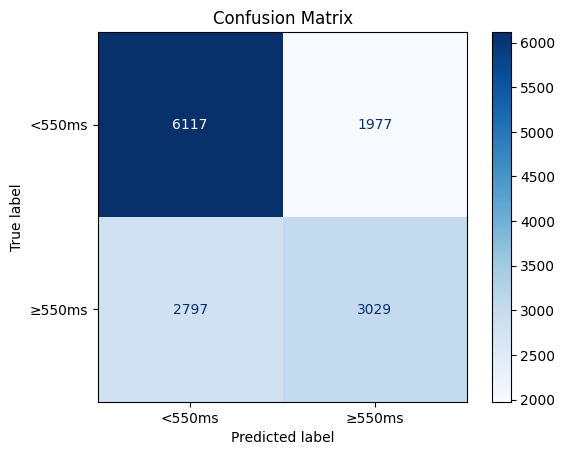

In [ ]:
params_svm = {'kernel': 'rbf', 'C': 9.272896048779563, 'degree': 1, 'tol': 1.2341484734155153, 'gamma': 'auto', 'coef0': -2.0827332014939346}
#{'kernel': 'poly', 'C': 6.986853818076061, 'degree': 2, 'tol': 0.07491954249556732, 'gamma': 'auto', 'coef0': 3.4443248098226604}

# Train the cuML SVC model on the GPU
cu_svm = cuML_SVC(**params_svm, class_weight='balanced', random_state=42).fit(X_train_cp, y_train_cp)

# Make predictions
y_pred_cu_svm = cu_svm.predict(X_test_cp)

# assess accuracy of the model
accuracy(y_test_cp.get(), y_pred_cu_svm.get())

# Evaluate the model
cu_svm_CM = matrix(y_test_cp.get(), y_pred_cu_svm.get())

share of 0`s in the dataset:  64.0%

accuracy:  62.3%

              precision    recall  f1-score   support

           0       0.78      0.58      0.66      8914
           1       0.48      0.71      0.57      5006

    accuracy                           0.62     13920
   macro avg       0.63      0.64      0.62     13920
weighted avg       0.67      0.62      0.63     13920



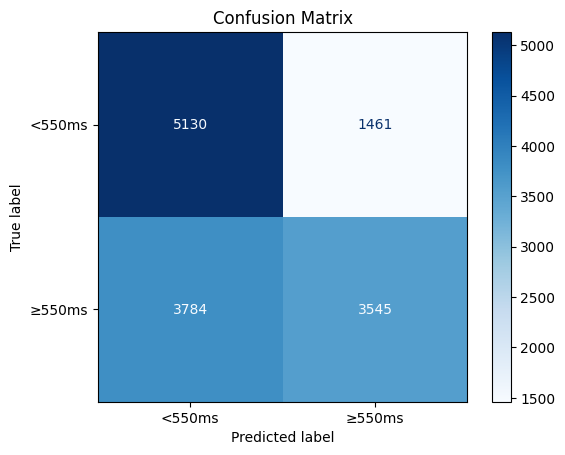

In [ ]:
# Train the cuML SVC model on the GPU
par = {'penalty': 'l2', 'loss': 'hinge', 'fit_intercept': True, 'C': 4.868118294463594, 'tol': 4.177510964718268e-06, 'max_iter': 1994}
par = {'penalty': 'l2', 'loss': 'hinge', 'fit_intercept': False, 'C': 6.616977720265101, 'tol': 0.026567906882030503, 'max_iter': 4471}
par = {'penalty': 'l2', 'loss': 'hinge', 'fit_intercept': False, 'C': 7.951036777321741, 'tol': 0.024188130071512652, 'max_iter': 4468}

lsvm = LinearSVC(**par, class_weight='balanced').fit(X_train_cp, y_train_cp)

# Make predictions
y_pred_lsvm = lsvm.predict(X_test_cp)

# assess accuracy of the model
accuracy(y_test_cp.get(), y_pred_lsvm.get())

# Evaluate the model
cu_svm_CM = matrix(y_test_cp.get(), y_pred_lsvm.get())

#### Random Forest:

/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


share of 0`s in the dataset:  64.0%

accuracy:  67.3%

              precision    recall  f1-score   support

           0       0.68      0.91      0.78      8914
           1       0.61      0.26      0.36      5006

    accuracy                           0.67     13920
   macro avg       0.65      0.58      0.57     13920
weighted avg       0.66      0.67      0.63     13920



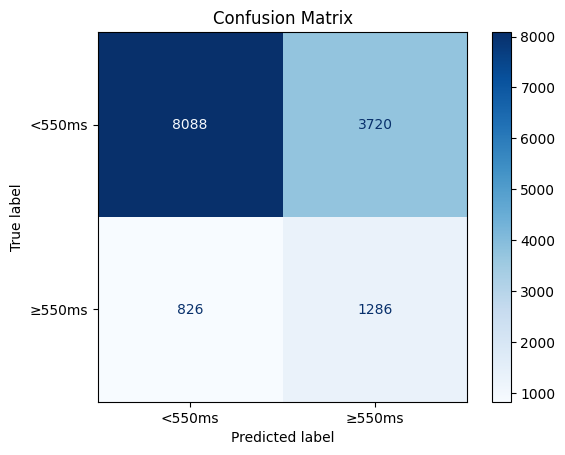

In [ ]:
params_rfc = {'n_estimators': 461, 'split_criterion': 1, 'max_depth': 28, 'max_features': 'sqrt', 'n_bins': 954}


# Train the cuML SVC model on the GPU
rfc_model = cuRFC(random_state=42).fit(X_train_cudf, y_train_cudf)

# Make predictions
y_pred_rfc = rfc_model.predict(X_test_cudf)

# assess accuracy of the model
accuracy(y_test_cudf.to_numpy(), y_pred_rfc.to_numpy())

# Evaluate the model
cu_rfc_CM = matrix(y_test_cudf.to_numpy(), y_pred_rfc.to_numpy())

## Boosting & Bagging

#### AdaBoost:

share of 0`s in the dataset:  64.0%

accuracy:  58.6%

              precision    recall  f1-score   support

           0       0.68      0.68      0.68      8914
           1       0.42      0.43      0.42      5006

    accuracy                           0.59     13920
   macro avg       0.55      0.55      0.55     13920
weighted avg       0.59      0.59      0.59     13920



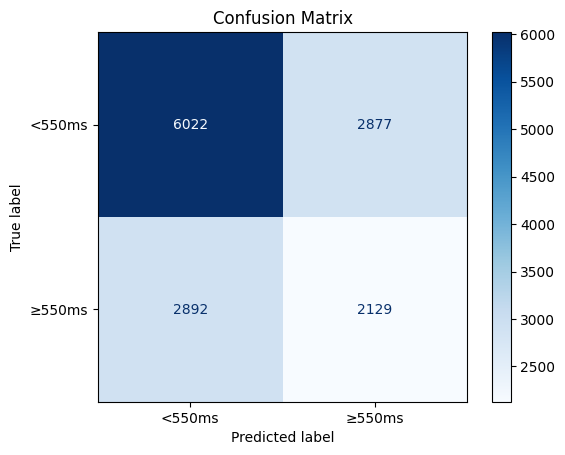

In [ ]:
adaboost_params = {'n_estimators': 172, 'learning_rate': 0.05010984676419275}
adaboost_model = AdaBoostClassifier(**adaboost_params, estimator = ExtraTreeClassifier(**{'criterion': 'log_loss'}),random_state=0)
adaboost_model.fit(X_train, y_train)
y_pred_adaboost = adaboost_model.predict(X_test)

# assess accuracy of the model
accuracy(y_test, y_pred_adaboost)

# Evaluate the model
adaboost_CM = matrix(y_test, y_pred_adaboost)

#### Bagging:

share of 0`s in the dataset:  64.0%

accuracy:  64.9%

              precision    recall  f1-score   support

           0       0.65      0.99      0.78      8914
           1       0.66      0.05      0.09      5006

    accuracy                           0.65     13920
   macro avg       0.65      0.52      0.44     13920
weighted avg       0.65      0.65      0.53     13920



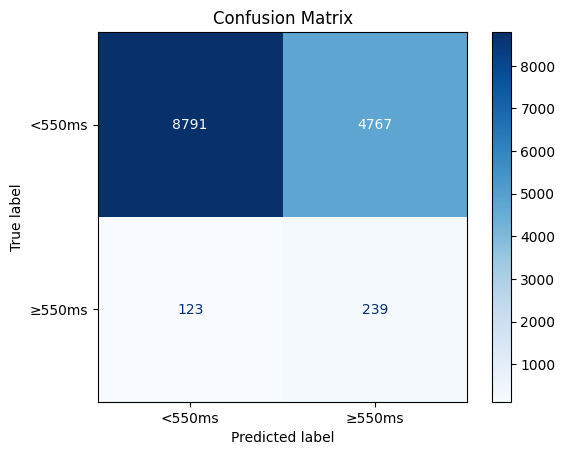

In [ ]:
bagging_model = BaggingClassifier(estimator=SVC(), n_estimators=10, random_state=0).fit(X_train, y_train)

y_pred_bagging = bagging_model.predict(X_test)

# assess accuracy of the model
accuracy(y_test, y_pred_bagging)

# Evaluate the model
bagging_CM = matrix(y_test, y_pred_bagging)

#### Gradient Boosting:

share of 0`s in the dataset:  64.0%

accuracy:  68.6%

              precision    recall  f1-score   support

           0       0.72      0.83      0.77      8914
           1       0.59      0.42      0.49      5006

    accuracy                           0.69     13920
   macro avg       0.65      0.63      0.63     13920
weighted avg       0.67      0.69      0.67     13920



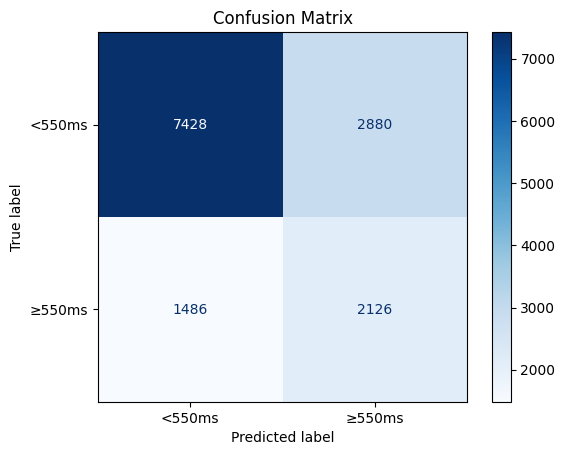

In [ ]:
gb_best_params = {'loss': 'log_loss', 'learning_rate': 0.2480860393372105, 'n_estimators': 268, 'subsample': 0.8869572213658536, 'criterion': 'friedman_mse', 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_depth': 5, 'min_impurity_decrease': 0.020756049939853638, 'max_features': None}
gb = GradientBoostingClassifier(**gb_best_params, random_state=0).fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

# assess accuracy of the model
accuracy(y_test, y_pred_gb)

# Evaluate the model
gb_CM = matrix(y_test, y_pred_gb)

Training of the models in this section is very slow (30+ mins), so even in case of good results, it would be of no use in real-life trading

## LDA & QDA

#### LDA:

share of 0`s in the dataset:  64.0%

accuracy:  57.1%

              precision    recall  f1-score   support

           0       0.73      0.52      0.61      8914
           1       0.44      0.66      0.52      5006

    accuracy                           0.57     13920
   macro avg       0.58      0.59      0.57     13920
weighted avg       0.62      0.57      0.58     13920



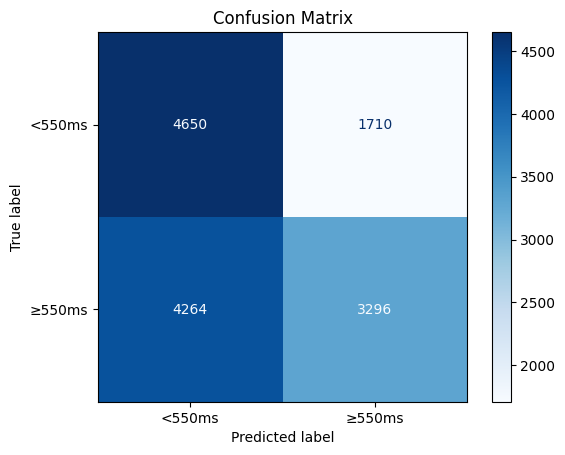

In [ ]:
lda_best_params = {'solver': 'eigen', 'tol': 0.02708586477650452, 'shrinkage': 0.99}

lda = LinearDiscriminantAnalysis(**lda_best_params).fit(X_train_scaled, y_train)

y_pred_lda = lda.predict(X_test_scaled)

# assess accuracy of the model
accuracy(y_test, y_pred_lda)

# Evaluate the model
lda_CM = matrix(y_test, y_pred_lda)

#### QDA:

share of 0`s in the dataset:  64.0%

accuracy:  45.9%

              precision    recall  f1-score   support

           0       0.77      0.22      0.34      8914
           1       0.39      0.88      0.54      5006

    accuracy                           0.46     13920
   macro avg       0.58      0.55      0.44     13920
weighted avg       0.63      0.46      0.41     13920



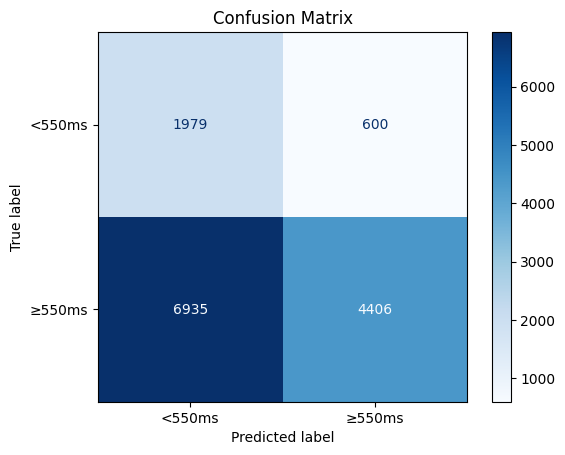

In [ ]:
qda_best_params = {'reg_param': 0.6859565331688875, 'tol': 0.1942110988316594}

qda = QuadraticDiscriminantAnalysis(**qda_best_params).fit(X_train_scaled, y_train)

y_pred_qda = qda.predict(X_test_scaled)

# assess accuracy of the model
accuracy(y_test, y_pred_qda)

# Evaluate the model
lda_CM = matrix(y_test, y_pred_qda)

## XGBoost

download the package:

In [ ]:
!pip install xgboost
from xgboost import XGBClassifier

In [ ]:
best_params = {'objective': 'binary:logistic',
 'eval_metric': 'error',
 'n_estimators': 827,
 'learning_rate': 0.5612403948506814,
 'max_depth': 9,
 'max_leaves': 6,
 'min_child_weight': 1,
 'subsample': 0.7377291105293949,
 'colsample_bytree': 0.854772161567795,
 'gamma': 1.3236554925385269,
 'reg_alpha': 0.00011289754307432173,
 'reg_lambda': 0.8602760073845163}

xgb_model = XGBClassifier(n_jobs=-1, **best_params).fit(X_train, y_train)

# evaluate on test set
y_pred_xgb  = xgb_model.predict(X_test)
# assess accuracy of the model
accuracy(y_test, y_pred_xgb)
# show confussion matrix
XGB_cm1 = matrix(y_test, y_pred_xgb)

## Deep Learning

#### Sklearn's neural network:

share of 0`s in the dataset:  64.0%

accuracy:  62.0%

              precision    recall  f1-score   support

           0       0.70      0.70      0.70      8914
           1       0.47      0.48      0.47      5006

    accuracy                           0.62     13920
   macro avg       0.59      0.59      0.59     13920
weighted avg       0.62      0.62      0.62     13920



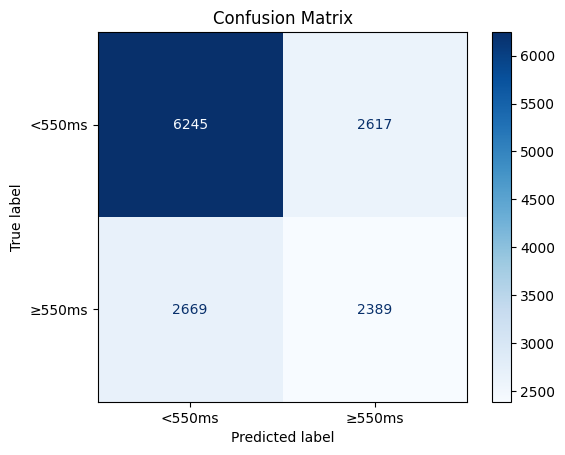

CPU times: user 3h 8min 25s, sys: 0 ns, total: 3h 8min 25s
Wall time: 24min 20s


In [ ]:
%%time
mlp_best_params = {'hidden_layer_sizes': tuple(200 for i in range(10)), 'activation': 'tanh', 'alpha': 0.00040577210838258686, 'learning_rate': 'invscaling', 'learning_rate_init': 6.821680619085213e-05, 'tol': 0.0013982717265945313, 'early_stopping': False}

mlp = MLPClassifier(**mlp_best_params).fit(X_train_scaled, y_train)

y_pred_mlp = mlp.predict(X_test_scaled)

# assess accuracy of the model
accuracy(y_test, y_pred_mlp)

# Evaluate the model
lda_CM = matrix(y_test, y_pred_mlp)

#### Tensorflow:

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense

435/435 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
share of 0`s in the dataset:  64.0%

accuracy:  63.8%

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      8914
           1       0.50      0.50      0.50      5006

    accuracy                           0.64     13920
   macro avg       0.61      0.61      0.61     13920
weighted avg       0.64      0.64      0.64     13920



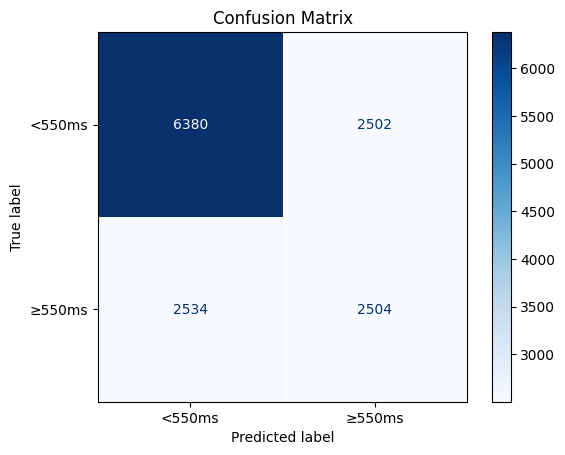

In [ ]:
nn_model = Sequential()

nn_model.add(Dense(units=10,                  # number of units the layer has
                activation='sigmoid',        # activation function
                 ))
nn_model.add(Dense(units=50,
                activation='relu',
                 ))
nn_model.add(Dense(units=10,
                activation='tanh',
                 ))
nn_model.add(Dense(units=100,
                activation='relu',
                 ))
nn_model.add(Dense(units=25,
                activation='sigmoid',
                 ))
nn_model.add(Dense(units=25,
                activation='relu',
                 ))
nn_model.add(Dense(units=100,
                activation='tanh',
                 ))
nn_model.add(Dense(units=10,
                activation='relu',
                 ))
nn_model.add(Dense(units=50,
                activation='sigmoid',
                 ))
nn_model.add(Dense(units=10,
                activation='relu',
                 ))

# Add output layer
nn_model.add(Dense(units=1, activation='sigmoid'))

# Compile model
nn_model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Fit
history = nn_model.fit(X_train_scaled, y_train,
                    epochs=1000,
                    batch_size=400,
                    verbose=0,
                   )

y_pred_nn_proba = nn_model.predict(X_test_scaled)
y_pred_nn = (y_pred_nn_proba > 0.5).astype(int)
# assess accuracy of the model
accuracy(y_test, y_pred_nn)
# Evaluate the model
nn_CM = matrix(y_test, y_pred_nn)

We can actually tinker with the proba values, since we are especially careful about false positives

share of 0`s in the dataset:  64.0%

accuracy:  45.0%

              precision    recall  f1-score   support

           0       0.81      0.19      0.30      8914
           1       0.39      0.92      0.55      5006

    accuracy                           0.45     13920
   macro avg       0.60      0.55      0.42     13920
weighted avg       0.66      0.45      0.39     13920



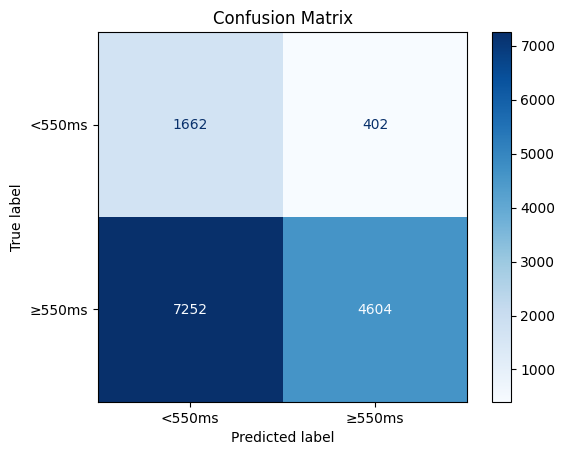

In [ ]:
y_pred_nn = (y_pred_nn_proba > 0.05).astype(int)
# assess accuracy of the model
accuracy(y_test, y_pred_nn)
# Evaluate the model
nn_CM = matrix(y_test, y_pred_nn)

# 3. Hyperparameter tuning

The biggest challenge is to pick the right set of parameters as well as the right accuracy metric. We really care about false positives, since we want to minimize our trading losses

In [ ]:
Cs = [0.01, 0.1, 1, 10, 100]

param_grid = [
    # solvers that only support l2 or no penalty
    {
        'solver': ['lbfgs','newton-cg','newton-cholesky','sag'],
        'fit_intercept': [True, False],
        'intercept_scaling': [1, 5, 10, 20],
        'penalty': ['l2', None],
        'tol': [1e-3, 1e-4, 1e-5],
        'C': Cs
    },

    # liblinear only supports l1 or l2
    {
        'solver': ['liblinear'],
        'fit_intercept': [True, False],
        'intercept_scaling': [1, 5, 10, 20],
        'penalty': ['l1','l2'],
        'tol': [1e-3, 1e-4, 1e-5],
        'C': Cs
    },

    # saga supports all four, but elasticnet *requires* l1_ratio
    {
        'fit_intercept': [True, False],
        'intercept_scaling': [1, 5, 10, 20],
        'solver': ['saga'],
        'penalty': ['l1','l2','elasticnet', None],
        'l1_ratio': [0.0, 0.5, 1.0],
        'tol': [1e-3, 1e-4, 1e-5],
        'C': Cs
    }
]

# NOTE: saga supports all three penalties
base = LogisticRegression(
    class_weight='balanced',
    max_iter=10000,
    random_state = 42
)

grid = GridSearchCV(
    base,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    refit=True
)

grid.fit(X_train_scaled, y_train)

print("Best params:", grid.best_params_)

# evaluate on test set
y_pred  = grid.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_pred, y_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["<550ms","≥550ms"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
solvers = ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']

# Base model
ridge = RidgeClassifier(class_weight='balanced', random_state=42)

# Grid definition
param_grid = {
    'alpha': alphas,
    'solver': solvers,
    'tol': [1e-4, 1e-3, 1e-2],
    'positive': [True, False]
}

# GridSearchCV
grid = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    refit=True
)

# Fit the grid
grid.fit(X_train_scaled, y_train)

# Best result
print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

y_pred_ridge  = grid.predict(X_test_scaled)
cm_ridge = matrix(y_test, y_pred_ridge)

In [ ]:
def objective_ridge(trial):
    # Define hyperparameters to tune
    positive = trial.suggest_categorical('positive', [True, False])

    if positive == False:
      params = {
          'alpha': trial.suggest_float("alpha", 0.01, 100),
          'solver': trial.suggest_categorical("solver", ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),
          'tol': trial.suggest_float("tol", 1e-4, 1e-2)
      }
    else:
      params = {
          'alpha': trial.suggest_float("alpha", 0.01, 100),
          'solver': 'lbfgs',
          'tol': trial.suggest_float("tol", 1e-4, 1e-1),
          'positive': True
      }

    # Create the XGBoost model with suggested hyperparameters
    model = RidgeClassifier(**params, class_weight='balanced', random_state=42)

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test_scaled)
    metric_value = f1_score(y_test, y_pred)

    return metric_value

# Create and run the Optuna study
study_ridge = optuna.create_study(direction="maximize")
study_ridge.optimize(objective_ridge, n_trials=1000, show_progress_bar=True)

study_pac.best_params

In [ ]:
def objective_xgb(trial):
    # Define hyperparameters to tune
    params = {
        "objective": trial.suggest_categorical("objective", ["binary:hinge", "binary:logistic"]),
        "eval_metric": trial.suggest_categorical("eval_metric", ["error", "auc"]),
        "random_state": 42,
        "n_jobs": -1,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        'max_leaves': trial.suggest_int("max_leaves", 0, 10),
        'min_child_weight': trial.suggest_int("min_child_weight", 0, 5),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 1.0, log=True),
    }

    # Create the XGBoost model with suggested hyperparameters
    model = XGBClassifier(**params)

    # Train the model
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    metric_value = f1_score(y_test, y_pred)

    return metric_value

# Create and run the Optuna study
study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=100, show_progress_bar=True)

study_pac.best_params

In [ ]:
def objective_sgd(trial):
    # Define hyperparameters to tune

    params = {
        'loss': trial.suggest_categorical("solver", ["hinge", "log_loss", "squared_hinge", "modified_huber", "perceptron", 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']),
        'penalty': trial.suggest_categorical("penalty", ["l2", "l1", "elasticnet", None]),
        'alpha': trial.suggest_float("alpha", 1e-5, 100),
        'l1_ratio': trial.suggest_float("l1_ratio", 0.0, 1.0),
        'fit_intercept': trial.suggest_categorical("fit_intercept", [True, False]),
        'tol': trial.suggest_float("tol", 0, 10),
        'shuffle' : trial.suggest_categorical("shuffle", [True, False]),
        'learning_rate': trial.suggest_categorical("learning_rate", ["constant", "optimal", "invscaling", "adaptive"]),
        'power_t': trial.suggest_float("power_t", -10, 10),
        'early_stopping': trial.suggest_categorical("early_stopping", [True, False]),
        'average' : trial.suggest_categorical("average", [False, True])

    }

    params['eta0'] = trial.suggest_float("eta0", 0, 10) if params['learning_rate'] in ("constant", "invscaling", "adaptive") else 0.0
    params['epsilon'] = trial.suggest_float("epsilon", 0, 10) if params['loss'] in ('huber', 'epsilon_insensitive', 'squared_epsilon_insensitive') else 0.0
    params['validation_fraction'] = 0.2 if params['early_stopping'] else 0.1
    params['n_iter_no_change'] = trial.suggest_int("n_iter_no_change", 5, 20) if params['early_stopping'] else 5
    params['max_iter'] = trial.suggest_int("max_iter", 100, 100000)

    # Create the model with suggested hyperparameters
    model = SGDClassifier(**params, class_weight='balanced', random_state=42, n_jobs=-1)

    # Train the model
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    metric_value = f1_score(y_test, y_pred)

    return metric_value

# Create and run the Optuna study
study_sgd = optuna.create_study(direction="maximize")
study_sgd.optimize(objective_sgd, n_trials=5000, show_progress_bar=True)

study_pac.best_params

In [ ]:
def objective_xgb(trial):
    # Define hyperparameters to tune
    params = {
        "objective": trial.suggest_categorical("objective", ["binary:hinge", "binary:logistic"]),
        "eval_metric": trial.suggest_categorical("eval_metric", ["error", "auc"]),
        "random_state": 42,
        "n_jobs": -1,
        'device': 'cuda',
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        'max_leaves': trial.suggest_int("max_leaves", 0, 10),
        'min_child_weight': trial.suggest_int("min_child_weight", 0, 5),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 1.0, log=True),
    }

    # Create the XGBoost model with suggested hyperparameters
    model = XGBClassifier(**params)

    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model

    y_pred = model.predict(X_test)
    metric_value = f1_score(y_test, y_pred)

    return metric_value

# Create and run the Optuna study
study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=100, show_progress_bar=True)

study_pac.best_params

In [ ]:
def objective_pac(trial):
    # Define hyperparameters to tune

    params = {
        'loss': trial.suggest_categorical("loss", ["hinge", "squared_hinge"]),
        'C': trial.suggest_float("C", 1e-5, 10),
        'fit_intercept': trial.suggest_categorical("fit_intercept", [True, False]),
        'tol': trial.suggest_float("tol", 0, 10)
    }

    # Create the model with suggested hyperparameters
    model = PassiveAggressiveClassifier(**params, class_weight='balanced', max_iter=100000, random_state=42, n_jobs=-1)

    # Train the model
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    metric_value = f1_score(y_test, y_pred)

    return metric_value

# Create and run the Optuna study
study_pac = optuna.create_study(direction="maximize")
study_pac.optimize(objective_pac, n_trials=5000, show_progress_bar=True)

study_pac.best_params

In [ ]:
def objective_SVM(trial):

    # Define hyperparameters to tune
    params = {
        'kernel': trial.suggest_categorical("kernel", ['poly', 'rbf', 'sigmoid']),
        'C': trial.suggest_float("C", 1e-5, 10),
        'degree': trial.suggest_int("degree", 1, 5),
        'tol': trial.suggest_float("tol", 0, 10),
        'gamma': trial.suggest_categorical("gamma", ['scale', 'auto']),
        'coef0': trial.suggest_float("coef0", -5, 5)
    }

    # Create the model with suggested hyperparameters
    model = cuML_SVC(**params, class_weight='balanced', random_state=42)

    # Train the model
    model.fit(X_train_cp, y_train_cp)

    # Predict
    y_pred = model.predict(X_test_cp)
    metric_value = precision_score(y_test_cp.get(), y_pred.get(), zero_division=0)

    return metric_value

# Create and run the Optuna study
study_pac = optuna.create_study(direction="maximize")
study_pac.optimize(objective_SVM, n_trials=5000, show_progress_bar=True)

study_pac.best_params

In [ ]:
def objective_lSVM(trial):
    params = {
        'penalty': trial.suggest_categorical("penalty", ['l1', 'l2']),
        'loss': trial.suggest_categorical("loss", ['squared_hinge', 'hinge']),
        'fit_intercept': trial.suggest_categorical("fit_intercept", [True, False]),
        'C': trial.suggest_float("C", 1e-5, 10.0, log=True),
        'tol': trial.suggest_float("tol", 1e-6, 1e-1),
        'max_iter': trial.suggest_int("max_iter", 1000, 10000),
    }

    model = LinearSVC(**params, class_weight='balanced')
    model.fit(X_train_cp, y_train_cp)

    y_pred = model.predict(X_test_cp)
    score = accuracy_score(y_test_cp.get(), y_pred.get())

    return score

# Run Optuna study
study_lsvm = optuna.create_study(direction="maximize")
study_lsvm.optimize(objective_lSVM, n_trials=1000, show_progress_bar=True)

print(study_lsvm.best_params)

In [ ]:
def objective_lSVM(trial):
    params = {
        'penalty': trial.suggest_categorical("penalty", ['l1', 'l2']),
        'loss': trial.suggest_categorical("loss", ['squared_hinge', 'hinge']),
        'fit_intercept': trial.suggest_categorical("fit_intercept", [True, False]),
        'C': trial.suggest_float("C", 1e-5, 10.0, log=True),
        'tol': trial.suggest_float("tol", 1e-6, 1e-1, log=True),
        'max_iter': trial.suggest_int("max_iter", 1000, 10000),
    }

    model = LinearSVC(**params, class_weight='balanced')
    model.fit(X_train_cp, y_train_cp)

    y_pred = model.predict(X_test_cp)
    tn, fp, fn, tp = confusion_matrix(y_test_cp.get(), y_pred.get()).ravel()

    return tp

# Run Optuna study
study_lsvm = optuna.create_study(direction="maximize")
study_lsvm.optimize(objective_lSVM, n_trials=1000, show_progress_bar=True)

print(study_lsvm.best_params)

In [ ]:
def objective_rfc(trial):
    params = {
        "n_estimators":          trial.suggest_int(   "n_estimators",    50,   5000),
        "split_criterion":       trial.suggest_categorical(
                                    "split_criterion", [0, 1]  # 0='gini', 1='entropy'
                                ),
        "max_depth":             trial.suggest_int(   "max_depth",      5,   50),
        "max_features":          trial.suggest_categorical(
                                    "max_features",  ["sqrt", "log2"]
                                ),
        "n_bins":                trial.suggest_int(   "n_bins",        128, 1024)
    }

    model = cuRFC(**params, random_state=42, n_streams=1)
    model.fit(X_train_cudf, y_train_cudf)

    y_pred = model.predict(X_test_cudf)
    score = f1_score(y_test_cudf.to_numpy(), y_pred.to_numpy())


    return score

# Run Optuna study
study_rfc = optuna.create_study(direction="maximize")
study_rfc.optimize(objective_rfc, n_trials=1000, show_progress_bar=True)

print(study_rfc.best_params)

In [ ]:
def objective_adaboost(trial):
    # Define hyperparameters to tune

    params = {
        'estimator':             trial.suggest_categorical("estimator", [None, 'DecisionTreeClassifier', 'ExtraTreeClassifier']),
        'n_estimators':          trial.suggest_int("n_estimators", 50, 250),
        "learning_rate":         trial.suggest_float("learning_rate", 0.01, 5, log = True)
    }

    if params['estimator'] == 'DecisionTreeClassifier':
          weak_params = {'criterion':             trial.suggest_categorical("criterion", ['gini', 'entropy', 'log_loss'])}
          max_depth_t = trial.suggest_categorical("max_depth_t", ['None', 'NotNone'])
          weak_params['max_depth'] = None if max_depth_t == 'None' else trial.suggest_int("max_depth", 50, 250)
          params['estimator'] = DecisionTreeClassifier(**weak_params, random_state = 42, class_weight="balanced")

    if params['estimator'] == 'ExtraTreeClassifier':
          weak_params = {
            'criterion':             trial.suggest_categorical("criterion", ['gini', 'entropy', 'log_loss']),
            'max_features':          trial.suggest_categorical("max_features", [None, 'sqrt', 'log2'])
            }
          max_depth_t = trial.suggest_categorical("max_depth_t", ['None', 'NotNone'])
          weak_params['max_depth'] = None if max_depth_t == 'None' else trial.suggest_int("max_depth", 50, 250)
          params['estimator'] = ExtraTreeClassifier(**weak_params, random_state = 42, class_weight="balanced")

    # Create the model with suggested hyperparameters
    model = AdaBoostClassifier(**params, random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    metric_value = f1_score(y_test, y_pred)

    return metric_value

# Create and run the Optuna study
study_adaboost = optuna.create_study(direction="maximize")
study_adaboost.optimize(objective_adaboost, n_trials=100, show_progress_bar=True)

study_adaboost.best_params

In [ ]:
def objective_gb(trial):
    # 1) sample hyperparameters
    params = {
        "loss":                    trial.suggest_categorical("loss", ["log_loss", "exponential"]),
        "learning_rate":           trial.suggest_float("learning_rate", 1e-3, 1.0, log = True),
        "n_estimators":            trial.suggest_int("n_estimators", 50, 500),
        "subsample":               trial.suggest_float("subsample", 0.5, 1.0),
        "criterion":               trial.suggest_categorical("criterion", ["friedman_mse", "squared_error"]),
        "min_samples_split":       trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf":        trial.suggest_int("min_samples_leaf", 1, 20),
        "max_depth":               trial.suggest_int("max_depth", 1, 10),
        "min_impurity_decrease":   trial.suggest_float("min_impurity_decrease", 0.0, 1e-1),
        "max_features":            trial.suggest_categorical("max_features", [None, "sqrt", "log2"]),
        "random_state":            42,
        # "n_iter_no_change":    trial.suggest_int("n_iter_no_change", 5, 50),
        # "validation_fraction": trial.suggest_float("validation_fraction", 0.1, 0.3),
    }

    clf = GradientBoostingClassifier(**params)

    # 2) 5-fold stratified CV, scoring by F1
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(
        clf, X_train, y_train,
        scoring='f1',
        cv=cv,
        n_jobs=-1
    ).mean()

    return score

# 3) run Optuna
study_gb = optuna.create_study(direction="maximize")
study_gb.optimize(objective_gb, n_trials=100, show_progress_bar=True)
study_gb.best_params

In [ ]:
def objective_lda(trial):

    solver = trial.suggest_categorical("solver", ["svd", "lsqr", "eigen"])
    tol = trial.suggest_float("tol", 1e-6, 1, log = True)
    if solver != "svd":
      shrinkage = trial.suggest_categorical("shrinkage", [None, "auto", 0.1, 0.25, 0.5, 0.75, 0.99])
      # build the model
      clf = LinearDiscriminantAnalysis(
          solver=solver,
          shrinkage=shrinkage,
          tol=tol
      )
    else:
      clf = LinearDiscriminantAnalysis(
          solver=solver,
          tol=tol
      )


    # 2) evaluate via CV
    try:
      cv = StratifiedKFold(n_splits=5, shuffle=True)
      scores = cross_val_score(
          clf,
          X_train_scaled, y_train,
          scoring='f1',
          cv=cv,
          n_jobs=-1
      ).mean()
    except:
      scores = 0
    return scores


study_lda = optuna.create_study(direction="maximize")
study_lda.optimize(objective_lda, n_trials=100, show_progress_bar=True)
study_lda.best_params

In [ ]:
def objective_qda(trial):
    # 1) Suggest QDA hyperparameters
    reg_param = trial.suggest_float("reg_param", 0.0, 1.0)
    tol        = trial.suggest_float("tol", 1e-6, 1, log=True)

    # 2) Build the model
    clf = QuadraticDiscriminantAnalysis(
        reg_param=reg_param,
        tol=tol
    )

    # 3) Evaluate with stratified 5-fold CV
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(clf, X_train_scaled, y_train, cv=cv, scoring="f1", n_jobs=-1).mean()
    return score

# 4) Run the study
study_qda = optuna.create_study(direction="maximize")
study_qda.optimize(objective_qda, n_trials=100)
study_qda.best_params

In [ ]:
def objective_mlp(trial):

    n_layers = 11
    hidden_layer_sizes = tuple(
        trial.suggest_int(f"n_units_l{i}", 32, 256)
        for i in range(n_layers - 2)
    )
    activation          = trial.suggest_categorical("activation", ["identity","logistic","tanh","relu"])
    alpha               = trial.suggest_float("alpha", 1e-6, 1, log = True)
    learning_rate       = trial.suggest_categorical("learning_rate", ["constant","invscaling","adaptive"])
    learning_rate_init  = trial.suggest_float("learning_rate_init", 1e-5, 1e-1, log = True)
    tol                 = trial.suggest_float("tol", 1e-5, 1e-2, log = True)
    early_stop          = trial.suggest_categorical("early_stopping", [True, False])


    model = MLPClassifier(
            hidden_layer_sizes=hidden_layer_sizes,
            activation=activation,
            alpha=alpha,
            learning_rate=learning_rate,
            learning_rate_init=learning_rate_init,
            tol=tol,
            early_stopping=early_stop,
            max_iter= 2000,
            random_state=42)

    # 3) Cross‐validate
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(
        model, X_train_scaled, y_train,
        cv=cv,
        scoring="f1",
        n_jobs=-1
    ).mean()

    return score

# 4) Run the study
study_mlp = optuna.create_study(direction="maximize")
study_mlp.optimize(objective_mlp, n_trials=50, show_progress_bar=True)
study_mlp.best_params

# 4. Model averaging

In [ ]:
X_avg = np.vstack([y_train_pred_svm, y_train_pred_log, y_train_pred_xgb])
X_test_avg = np.vstack([y_pred_svm, y_pred, y_pred_xgb])

beta = np.linalg.pinv(X_avg.T) @ y_train

y_pred_avg = X_test_avg.T @ beta
y_pred_avg_binary = (y_pred_avg >= 0.5).astype(int)
y_pred_avg_binary

accuracy_score(y_test, y_pred_avg_binary)

# 5. Backtesting

In this section we want to calculate our PnL using different models

Upload the models:

In [ ]:
scaler = joblib.load('/content/drive/MyDrive/scaler.pkl')

logit = joblib.load('/content/drive/MyDrive/logit.pkl')

df_n = pl.read_parquet('/content/drive/MyDrive/df_n.parquet')
arbitrage_model = pl.read_parquet('/content/drive/MyDrive/arbitrage_model.parquet')
arbitrage_model = arbitrage_model.to_pandas()


In [ ]:
pl.Config.set_tbl_rows(55)

polars.config.Config

Support functions:

In [ ]:
def matrices(
    expected_df: pl.DataFrame,
    realized_df_buy: pl.DataFrame,
    realized_df_sell: pl.DataFrame,
    buy_exchange: str,
    sell_exchange: str,
    investment: int,
    threshold: int,
    buy_ts_list: np.ndarray = np.array([]),
    sell_ts_list: np.ndarray = np.array([]),
  ):
  '''
  This support function is used to form matrices of price-size pairs that satisfy our conditions:
  open orders remain outstanding till either the correspoding offsetting deal is met during the trading session or till the end of the trading session.
  '''
  # Prices and sizes that are used for decision-making
  expected_buy_price = expected_df.select(pl.col(f'{buy_exchange}_level1_price_ask')).item()
  available_buy_size = expected_df.select(pl.col(f'{buy_exchange}_level1_size_ask')).item()

  expected_sell_price = expected_df.select(pl.col(f'{sell_exchange}_level1_price_bid')).item()
  available_sell_size = expected_df.select(pl.col(f'{sell_exchange}_level1_size_bid')).item()

  # check liquidity volumes
  expected_buy_liquidity = expected_buy_price * available_buy_size
  expected_sell_liquidity = expected_sell_price * available_sell_size
  expected_arbitrage_size = min(investment, expected_buy_liquidity, expected_sell_liquidity)

  if expected_arbitrage_size >= threshold: # we are not interested in placing orders smaller than a certain amount

    expected_size = round(expected_arbitrage_size / expected_buy_price, 2)

    # We assume that if order is not executed immediately, it remains open till the end of the trading session. Here we form the matrices of all the potential deals
    buy_price_matrix = realized_df_buy.select(pl.col(f'{buy_exchange}_level{i}_price_ask' for i in range(1,4))).to_numpy()
    buy_size_matrix = realized_df_buy.select(pl.col(f'{buy_exchange}_level{i}_size_ask' for i in range(1,4))).to_numpy()

    sell_price_matrix = realized_df_sell.select(pl.col(f'{sell_exchange}_level{i}_price_bid' for i in range(1,4))).to_numpy()
    sell_size_matrix = realized_df_sell.select(pl.col(f'{sell_exchange}_level{i}_size_bid' for i in range(1,4))).to_numpy()

    buy_matrix_1 = buy_price_matrix[buy_price_matrix <= expected_buy_price]
    buy_matrix_2 = buy_size_matrix[buy_price_matrix <= expected_buy_price]
    buy_matrix = np.c_[buy_matrix_1, buy_matrix_2]

    # we want to get rid of duplicates
    _, unique_indices = np.unique(buy_matrix, axis=0, return_index=True)
    buy_matrix = buy_matrix[np.sort(unique_indices)]

    buy_ts = np.repeat(realized_df_buy.select(pl.col('ts')).to_numpy(), 3, axis = 1)
    buy_ts = buy_ts[buy_price_matrix <= expected_buy_price]
    buy_ts = buy_ts[np.sort(unique_indices)]


    buy_matrix = buy_matrix[~np.isin(buy_ts, buy_ts_list)]  #exclude observations that were used in previous cycles
    buy_ts = buy_ts[~np.isin(buy_ts, buy_ts_list)]


    sell_matrix_1 = sell_price_matrix[sell_price_matrix >= expected_sell_price]
    sell_matrix_2 = sell_size_matrix[sell_price_matrix >= expected_sell_price]
    sell_matrix = np.c_[sell_matrix_1, sell_matrix_2]

    _, unique_indices = np.unique(sell_matrix, axis=0, return_index=True)
    sell_matrix = sell_matrix[np.sort(unique_indices)]

    sell_ts = np.repeat(realized_df_sell.select(pl.col('ts')).to_numpy(), 3, axis = 1)
    sell_ts = sell_ts[sell_price_matrix >= expected_sell_price]
    sell_ts = sell_ts[np.sort(unique_indices)]

    sell_matrix = sell_matrix[~np.isin(sell_ts, sell_ts_list)]
    sell_ts = sell_ts[~np.isin(sell_ts, sell_ts_list)]

    return buy_matrix, sell_matrix, buy_ts, sell_ts, expected_arbitrage_size, expected_size, expected_buy_price, expected_sell_price, available_buy_size, available_sell_size

  else:
    logger.info(f'low liquidity: ${expected_arbitrage_size: .2f}')
    return



def match_volume(mat: np.ndarray, target_volume: float, ts = None) -> np.ndarray:
  '''
  This support function is used to match available open positions with the expected order size or to match volumes between orders at two exchanges:
  it can be the case that at one exchange the volumes are enough to execute the (expected) order,
  while on the other exchange the price or volume might have changed faster than the order was placed.
  Hence, all the coins beyond offsetting deals should be considered as inventories and kept till the end of the trading session, when they are sold at the market price
  '''
  if target_volume == 0:
    return np.zeros((0, 2))

  prices = mat[:, 0]
  sizes  = mat[:, 1]

  # 1) compute cumulative sum of sizes
  cumsum_sizes = np.cumsum(sizes)

  # 2) find the first index where cumsum_sizes >= target_volume
  idx = np.searchsorted(cumsum_sizes, target_volume, side="left")

  if idx >= len(mat):
      # All levels are needed, but the total sum could be <= target_volume.
      # In that case, just return the entire matrix.
      if ts is not None:
          return mat.copy(), ts.copy()
      else:
          return mat.copy()

  # 3) build the trimmed matrix: take all full levels BEFORE idx,
  #    and a partial level at idx so that we hit exactly target_volume.
  if idx == 0:
      # Even the very first level already exceeds target_volume,
      # so we only take part of the first row.
      truncated_size = target_volume
      new_rows = np.array([[prices[0], truncated_size]])
      if ts is not None:
          return new_rows, ts[0]
      else:
          return new_rows

  # Otherwise, we take all levels 0..idx-1 in full, and a partial of level idx
  full_rows      = mat[:idx]  # all rows before idx
  vol_before_idx = cumsum_sizes[idx - 1]  # cumulative volume up to (idx-1)

  # how much volume we still need at level idx
  expected_vol = target_volume - vol_before_idx
  # prices[idx] is the price at that level; we allocate expected_vol volume there:
  last_row = np.array([[prices[idx], expected_vol]])

  # concatenate
  if ts is not None:
      return np.vstack([full_rows, last_row]), ts[:idx+1]
  else:
      return np.vstack([full_rows, last_row])

def build_support_matrix(full_matrix: np.ndarray, matched: np.ndarray) -> np.ndarray:
  '''
  support function to calculate outstanding inventories
  '''
  if full_matrix.shape[0] == 0: #no inventories
      return np.zeros((0, 2))
  # number of fully matched rows is matched.shape[0]
  k = matched.shape[0]
  # subtract matched volumes from the first k rows:
  support = full_matrix[:k].copy()
  support[:,1] = support[:,1] - matched[:,1]

  # if there is a “next” level that was partially used, append it:
  if k < full_matrix.shape[0]:
      support = np.vstack([support, full_matrix[k]])
  return support


def backtesing(trained_model, scaler, arbitrage_model, df_n, trading_hours, HTX_execution_time, Bybit_execution_time, investment, threshold, start_timestamp_ms):
  '''
  The main function to backtest different models by calculating the PnL.
  '''
  total_missed_opportunity = 0
  total_expected_profit = 0
  total_realized_profit = 0
  HTX_inventory = np.empty((0, 2))
  Bybit_inventory = np.empty((0, 2))
  HTX_open_orders = np.empty((0, 2))
  Bybit_open_orders = np.empty((0, 2))
  buy_ts_list = np.array([])
  sell_ts_list = np.array([])
  prediction_time_list = np.array([])
  number_of_bBsH = 0
  number_of_bHsB = 0

  # Calculate the end timestamp (24 hours later in milliseconds)
  duration_ms = trading_hours * 60 * 60 * 1000
  end_timestamp_ms = start_timestamp_ms + duration_ms

  # Filter the DataFrame for the 24-hour period
  df_filtered = df_n.filter(
      (pl.col('ts') >= start_timestamp_ms) & (pl.col('ts') <= end_timestamp_ms)
  )

  start = df_filtered.select(pl.col('ts'))[0].item()
  end = df_filtered.select(pl.col('ts'))[-1].item()

  row_start = arbitrage_model[arbitrage_model.ts >= start].index[0]
  row_end = arbitrage_model[arbitrage_model.ts <= end].index[-1]

  X = arbitrage_model.drop(columns = ['ts', 'length', 'dummy', 'arbitrage_id'])
  y = arbitrage_model["dummy"]

  for pos in range(row_start, row_end):
    logger.info(f'Row number: {pos}')
    now = time.time()
    X_scaled = scaler.transform(X.iloc[pos:pos+1])

    prediction = trained_model.predict(X_scaled)[0]
    true_value = y.iloc[pos]

    logger.info(f'prediction: {prediction};\ttrue value: {true_value}')

    prediction_time = time.time() - now
    prediction_time_list = np.append(prediction_time_list, prediction_time)

    if prediction_time > 0.05:
      logger.info(f'prediction time: {prediction_time: .2f}')

    ts = arbitrage_model.loc[pos, 'ts']

    # the tick info we use to predict the outcome
    expected_df = df_filtered.filter(pl.col('ts') == ts)[0]

    # the most
    realized_df_HTX = (
      df_filtered
      .filter(pl.col('ts') >= (ts + HTX_execution_time + prediction_time))
    )
    realized_df_Bybit = (
      df_filtered
      .filter(pl.col('ts') >= (ts + Bybit_execution_time + prediction_time))
    )

    if prediction == 1:

      if expected_df.select(pl.col('arb_opportunity')).item() > 0: #buy at HTX, sell at Bybit
        strategy = "bHsB"
        logger.info(f'strategy: {strategy}')
        try:
          buy_matrix, sell_matrix, buy_ts_matrix, sell_ts_matrix, expected_arbitrage_size, expected_size, expected_buy_price, expected_sell_price, available_buy_size, available_sell_size = matrices(
              expected_df = expected_df,
              realized_df_buy = realized_df_HTX,
              realized_df_sell = realized_df_Bybit,
              buy_exchange = 'HTX',
              sell_exchange = 'Bybit',
              investment = investment,
              threshold = threshold,
              buy_ts_list = buy_ts_list,
              sell_ts_list = sell_ts_list)
          number_of_bHsB += 1

        except:
          continue


      elif expected_df.select(pl.col('arb_opportunity')).item() < 0:
        strategy = "bBsH"
        logger.info(f'strategy: {strategy}')

        try:
          buy_matrix, sell_matrix, buy_ts_matrix, sell_ts_matrix, expected_arbitrage_size, expected_size, expected_buy_price, expected_sell_price, available_buy_size, available_sell_size = matrices(
              expected_df = expected_df,
              realized_df_buy = realized_df_Bybit,
              realized_df_sell = realized_df_HTX,
              buy_exchange = 'Bybit',
              sell_exchange = 'HTX',
              investment = investment,
              threshold = threshold,
              buy_ts_list = buy_ts_list,
              sell_ts_list = sell_ts_list)

          number_of_bBsH += 1

        except:
          continue

      if buy_matrix.size != 0:
        realized_buy_matrix, buy_ts = match_volume(buy_matrix, expected_size, buy_ts_matrix)
        realized_buy_size = np.sum(realized_buy_matrix[:,1])
      else:
        realized_buy_matrix = np.zeros((0, 2))
        realized_buy_size = 0

      if sell_matrix.size != 0:
        realized_sell_matrix, sell_ts = match_volume(sell_matrix, expected_size, sell_ts_matrix)
        realized_sell_size = np.sum(realized_sell_matrix[:,1])
      else:
        realized_sell_matrix = np.zeros((0, 2))
        realized_buy_size = 0


      if realized_buy_size == realized_sell_size:
          buy_matched  = realized_buy_matrix
          sell_matched = realized_sell_matrix
      else:
          realized_size = min(realized_buy_size, realized_sell_size)
          buy_matched  = match_volume(realized_buy_matrix,  realized_size)
          sell_matched = match_volume(realized_sell_matrix, realized_size)

          support_buy_matrix  = build_support_matrix(realized_buy_matrix,  buy_matched)
          support_sell_matrix = build_support_matrix(realized_sell_matrix, sell_matched)

          if strategy == "bHsB":
            support_sell_matrix[:, 1] *= -1
            HTX_inventory = np.vstack([HTX_inventory, support_buy_matrix])
            Bybit_inventory = np.vstack([Bybit_inventory, support_sell_matrix])
          elif strategy == "bBsH":
            support_sell_matrix[:, 1] *= -1
            HTX_inventory = np.vstack([HTX_inventory, support_sell_matrix])
            Bybit_inventory = np.vstack([Bybit_inventory, support_buy_matrix])

      buy_ts_list = np.append(buy_ts_list, buy_ts)
      sell_ts_list = np.append(sell_ts_list, sell_ts)


      realized_profit = sell_matched[:, 0] @ sell_matched[:, 1] - buy_matched[:, 0] @ buy_matched[:, 1]
      realized_profit = round(realized_profit, 2)
      total_realized_profit += realized_profit

      expected_profit = expected_arbitrage_size * (expected_sell_price/expected_buy_price - 1)
      total_expected_profit += expected_profit

      logger.info(f'trades no: \nbHsB {number_of_bHsB}\nbBsH {number_of_bBsH}')
      '''
      logger.info(f"""Expected values:
      actual ts: {ts}
      buy price, $: {expected_buy_price}, buy size, LTC: {available_buy_size}
      sell price, $: {expected_sell_price}, sell size, LTC: {available_sell_size}
      profit, $: {expected_profit:.2f}
      """)

      logger.info(f"""Realized values:
      buy ts: {buy_ts}, buy ts diff: {buy_ts - ts},
      sell ts: {sell_ts}, sell ts diff: {sell_ts - ts}
      realized buy matrix: {realized_buy_matrix}, realized sell matrix: {realized_sell_matrix}
      matched buy matrix: {buy_matched}, matched sell matrix: {sell_matched}
      HTX inventory: \n{HTX_inventory}
      Bybit inventory: \n{Bybit_inventory}
      profit, $: {realized_profit:.2f}
      """)
      '''



    if prediction == 0 and true_value == 1:
      if expected_df.select(pl.col('arb_opportunity')).item() > 0:

        realized_buy_price = realized_df_HTX.select(pl.col('HTX_level1_price_ask'))[0].item()
        realized_buy_size = realized_df_HTX.select(pl.col('HTX_level1_size_ask'))[0].item()

        realized_sell_price = realized_df_Bybit.select(pl.col('Bybit_level1_price_bid'))[0].item()
        realized_sell_size = realized_df_Bybit.select(pl.col('Bybit_level1_size_bid'))[0].item()

      if expected_df.select(pl.col('arb_opportunity')).item() < 0:

        realized_buy_price = realized_df_Bybit.select(pl.col('Bybit_level1_price_ask'))[0].item()
        realized_buy_size = realized_df_Bybit.select(pl.col('Bybit_level1_size_ask'))[0].item()

        realized_sell_price = realized_df_HTX.select(pl.col('HTX_level1_price_bid'))[0].item()
        realized_sell_size = realized_df_HTX.select(pl.col('HTX_level1_size_bid'))[0].item()


      realized_buy_liquidity = realized_buy_price * realized_buy_size
      realized_sell_liquidity = realized_sell_price * realized_sell_size
      realized_arbitrage_size = min(investment, realized_buy_liquidity, realized_sell_liquidity)
      missed_opportunity = realized_arbitrage_size * (realized_sell_price/realized_buy_price - 1)

      logger.info(f'missed opportunity, $: {missed_opportunity: .2f}')
      total_missed_opportunity += missed_opportunity

  logger.info(f'Cycle ended. Results:')
  logger.info(f'total expected profit, $: {total_expected_profit: .2f}')
  logger.info(f'total realized profit, $: {total_realized_profit: .2f}')
  logger.info(f'total missed opportunity, $: {total_missed_opportunity: .2f}')
  logger.info(f'HTX inventory: \n{HTX_inventory}')
  logger.info(f'Bybit inventory: \n{Bybit_inventory}')

  last_ask_price_HTX = realized_df_HTX.select(pl.col('HTX_level1_price_ask'))[-1].item()
  last_bid_price_HTX = realized_df_HTX.select(pl.col("HTX_level1_price_bid"))[-1].item()
  last_ask_price_Bybit = realized_df_Bybit.select(pl.col("Bybit_level1_price_ask"))[-1].item()
  last_bid_price_Bybit = realized_df_Bybit.select(pl.col("Bybit_level1_price_bid"))[-1].item()

  logger.info(f'last HTX prices: \nask: {last_ask_price_HTX};\nbid: {last_bid_price_HTX}')
  logger.info(f'last Bybit prices: \nask: {last_ask_price_Bybit};\nbid: {last_bid_price_Bybit}')
  return total_expected_profit, total_realized_profit, total_missed_opportunity, HTX_inventory, Bybit_inventory, last_ask_price_HTX, last_bid_price_HTX, last_ask_price_Bybit, last_bid_price_Bybit, buy_ts_list, sell_ts_list, np.mean(prediction_time_list)


In [ ]:
trading_hours = 2
HTX_execution_time = 500  #ms to execute a trade on HTX
Bybit_execution_time = 500  #ms to execute a trade on Bybit
investment = 200 #usdt per single arbitrage operation
threshold = 100 #minimum arbitrage value


# Define the start timestamp (replace with your desired start time)
start_timestamp_ms = 1744839000000 + 6 * 60 * 60 * 1000  #2025-04-17

In [ ]:
total_expected_profit, total_realized_profit, total_missed_opportunity, HTX_inventory, Bybit_inventory, last_ask_price_HTX, last_bid_price_HTX, last_ask_price_Bybit, last_bid_price_Bybit, buy_ts_list, sell_ts_list, prediction_time = backtesing(logit, scaler, arbitrage_model, df_n, trading_hours, HTX_execution_time, Bybit_execution_time, investment, threshold, start_timestamp_ms)


Выходные данные были обрезаны до нескольких последних строк (5000).
      
2025-06-11 22:05:37,096 - INFO - Row number: 5056
2025-06-11 22:05:37,102 - INFO - prediction: 0;	true value: 0
2025-06-11 22:05:37,109 - INFO - Row number: 5057
2025-06-11 22:05:37,114 - INFO - prediction: 0;	true value: 0
2025-06-11 22:05:37,123 - INFO - Row number: 5058
2025-06-11 22:05:37,128 - INFO - prediction: 1;	true value: 0
2025-06-11 22:05:37,136 - INFO - strategy: bHsB
2025-06-11 22:05:37,308 - INFO - trades no: 
bHsB 2060
bBsH 20
2025-06-11 22:05:37,309 - INFO - Expected values:
      actual ts: 1744920268536
      buy price, $: 75.32, buy size, LTC: 32.7063
      sell price, $: 75.35, sell size, LTC: 28.60046
      profit, $: 0.08
      
2025-06-11 22:05:37,311 - INFO - Realized values:
      buy ts: 1744920270553, buy ts diff: 2017,
      sell ts: 1744920269053, sell ts diff: 517
      realized buy matrix: [[75.32  2.66]], realized sell matrix: [[75.35  2.66]]
      matched buy matrix: [[75.32  2.

# 6. Appendix

In [ ]:
# Get feature names
feature_names = X_train.columns

# Get the coefficients from the fitted model
coefficients = clf.coef_[0]

# Create a list of (feature_name, coefficient) pairs
feature_importance = list(zip(feature_names, coefficients))

# Sort the features by the absolute value of their coefficients
feature_importance_sorted = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=False)

# Print the sorted list of feature importance
print("Most important features for Logistic Regression:")
for feature, coef in feature_importance_sorted:
    print(f"{feature}: {coef}")

Most important features for Logistic Regression:
Bybit_level3_size_bid_vs_max_lag_2: -0.00035032582797596716
Bybit_level3_size_bid_vs_max_lag_4: -0.00040969504486808805
HTX_level3_size_bid_vs_min_lag_2: 0.000572664445685269
HTX_level1_size_bid_vs_avg_lag_1: 0.0007044851684712561
HTX_level3_size_bid_vs_min_lag_5: 0.0008122527489644061
Bybit_level1_size_bid_vs_avg_lag_5: 0.0009457582916346165
Bybit_level2_size_bid_vs_min_lag_5: 0.000963557376971011
HTX_level1_imbalance_lag_2: 0.0010550005198757101
HTX_level3_size_bid_vs_avg_lag_4: -0.0010707059074543499
Bybit_level1_size_bid_vs_min_lag_2: 0.0011220685614908702
HTX_level2_size_bid_vs_max_lag_2: -0.001211968900127117
HTX_level1_price_bid_vs_max_lag_3: 0.0012772196400373862
HTX_level2_price_ask_vs_min: 0.0014353802820373978
Bybit_level2_size_bid_vs_min_lag_4: -0.0015343747250907156
HTX_level3_price_bid_vs_max_lag_5: 0.0016322816191387261
HTX_level3_size_ask_vs_avg_lag_4: 0.0018140189947951995
Bybit_level1_size_bid_vs_max_lag_4: 0.0018263619

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    clf, X_test_scaled, y_test,
    scoring='f1',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

perm_imp = pd.Series(result.importances_mean, index=X_test.columns)
perm_imp = perm_imp.sort_values(ascending=False)

print("Top 10 by permutation importance:")
print(perm_imp.head(10))

KeyboardInterrupt: 

In [ ]:
arbitrage_model_2['hour'] = pd.to_datetime(arbitrage_model_2['ts'], unit = 'ms').dt.hour
hour_data = arbitrage_model_2[['hour']]

encoder = OneHotEncoder(drop='first', sparse_output=False)


hour_encoded = encoder.fit_transform(hour_data)
encoded_hour_df = pd.DataFrame(hour_encoded, columns=encoder.get_feature_names_out(['hour']))
encoded_hour_df.index = arbitrage_model_2.index
arbitrage_model_2_with_hour_dummies = pd.concat([arbitrage_model_2, encoded_hour_df], axis=1)
arbitrage_model_2_with_hour_dummies = arbitrage_model_2_with_hour_dummies.drop('hour', axis=1)

In [ ]:
arbitrage_model_2_with_hour_dummies

In [ ]:
X = arbitrage_model_2_with_hour_dummies.drop(columns = ['ts', 'length', 'dummy', 'arbitrage_id' ])
y = arbitrage_model_2_with_hour_dummies["dummy"]

# 5) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = LogisticRegression(**{'C': 1, 'fit_intercept': True, 'intercept_scaling': 1, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.001}, class_weight='balanced', max_iter=10000).fit(X_train_scaled, y_train)

# evaluate on test set
y_pred  = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_pred, y_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["<550ms","≥550ms"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

t2 = X_train.index.sort_values()

In [ ]:
def feature_selection_2(df, exchange1, exchange2):
    df_train = df.select([
        pl.col(["ts", "Bybit_delta_ts", 'HTX_delta_ts', 'timedelta', 'arbitrage_id', "arb_opportunity", 'length', 'till_arbitrage', 'since_last_arbitrage', 'arbitrage_start', 'active_arbitrage']),

        # Spreads
        (pl.col(f"{exchange1}_level1_price_ask") - pl.col(f"{exchange1}_level1_price_bid")
        ).cast(pl.Float32).alias(f"{exchange1}_level1_bid_ask_spread"),
        (pl.col(f"{exchange1}_level2_price_ask") - pl.col(f"{exchange1}_level2_price_bid")
        ).cast(pl.Float32).alias(f"{exchange1}_level2_bid_ask_spread"),
        (pl.col(f"{exchange1}_level3_price_ask") - pl.col(f"{exchange1}_level3_price_bid")
        ).cast(pl.Float32).alias(f"{exchange1}_level3_bid_ask_spread"),

        (pl.col(f"{exchange1}_level2_price_ask") - pl.col(f"{exchange1}_level1_price_ask")
        ).cast(pl.Float32).alias(f"{exchange1}_level1_ask_spread"),
        (pl.col(f"{exchange1}_level3_price_ask") - pl.col(f"{exchange1}_level2_price_ask")
        ).cast(pl.Float32).alias(f"{exchange1}_level2_ask_spread"),

        (pl.col(f"{exchange1}_level1_price_bid") - pl.col(f"{exchange1}_level2_price_bid")
        ).cast(pl.Float32).alias(f"{exchange1}_level1_bid_spread"),
        (pl.col(f"{exchange1}_level2_price_bid") - pl.col(f"{exchange1}_level3_price_bid")
        ).cast(pl.Float32).alias(f"{exchange1}_level2_bid_spread"),

        (pl.col(f"{exchange2}_level1_price_ask") - pl.col(f"{exchange2}_level1_price_bid")
        ).cast(pl.Float32).alias(f"{exchange2}_level1_bid_ask_spread"),
        (pl.col(f"{exchange2}_level2_price_ask") - pl.col(f"{exchange2}_level2_price_bid")
        ).cast(pl.Float32).alias(f"{exchange2}_level2_bid_ask_spread"),
        (pl.col(f"{exchange2}_level3_price_ask") - pl.col(f"{exchange2}_level3_price_bid")
        ).cast(pl.Float32).alias(f"{exchange2}_level3_bid_ask_spread"),

        (pl.col(f"{exchange2}_level1_price_bid") - pl.col(f"{exchange2}_level2_price_bid")
        ).cast(pl.Float32).alias(f"{exchange2}_level1_bid_spread"),
        (pl.col(f"{exchange2}_level2_price_bid") - pl.col(f"{exchange2}_level3_price_bid")
        ).cast(pl.Float32).alias(f"{exchange2}_level2_bid_spread"),

        (pl.col(f"{exchange2}_level2_price_ask") - pl.col(f"{exchange2}_level1_price_ask")
        ).cast(pl.Float32).alias(f"{exchange2}_level1_ask_spread"),
        (pl.col(f"{exchange2}_level3_price_ask") - pl.col(f"{exchange2}_level2_price_ask")
        ).cast(pl.Float32).alias(f"{exchange2}_level2_ask_spread"),


        # Imbalance
        ((pl.col(f"{exchange1}_level1_size_bid") - pl.col(f"{exchange1}_level1_size_ask")) /
         (pl.col(f"{exchange1}_level1_size_bid") + pl.col(f"{exchange1}_level1_size_ask"))
        ).alias(f"{exchange1}_level1_imbalance"),

        ((pl.col(f"{exchange2}_level1_size_bid") - pl.col(f"{exchange2}_level1_size_ask")) /
         (pl.col(f"{exchange2}_level1_size_bid") + pl.col(f"{exchange2}_level1_size_ask"))
        ).alias(f"{exchange2}_level1_imbalance"),

        ((pl.col(f"{exchange1}_level1_size_bid") + pl.col(f"{exchange1}_level2_size_bid") + pl.col(f"{exchange1}_level3_size_bid") -
          pl.col(f"{exchange1}_level1_size_ask") - pl.col(f"{exchange1}_level2_size_ask") - pl.col(f"{exchange1}_level3_size_ask")) /
         (pl.col(f"{exchange1}_level1_size_bid") + pl.col(f"{exchange1}_level2_size_bid") + pl.col(f"{exchange1}_level3_size_bid") +
          pl.col(f"{exchange1}_level1_size_ask") + pl.col(f"{exchange1}_level2_size_ask") + pl.col(f"{exchange1}_level3_size_ask"))
        ).alias(f"{exchange1}_aggregated_imbalance"),

        ((pl.col(f"{exchange2}_level1_size_bid") + pl.col(f"{exchange2}_level2_size_bid") + pl.col(f"{exchange2}_level3_size_bid") -
          pl.col(f"{exchange2}_level1_size_ask") - pl.col(f"{exchange2}_level2_size_ask") - pl.col(f"{exchange2}_level3_size_ask")) /
         (pl.col(f"{exchange2}_level1_size_bid") + pl.col(f"{exchange2}_level2_size_bid") + pl.col(f"{exchange2}_level3_size_bid") +
          pl.col(f"{exchange2}_level1_size_ask") + pl.col(f"{exchange2}_level2_size_ask") + pl.col(f"{exchange2}_level3_size_ask"))
        ).alias(f"{exchange2}_aggregated_imbalance"),

        # Relative VWAP
        (pl.col(f"{exchange1}_level1_price_bid") *
         (pl.col(f"{exchange1}_level1_size_bid") + pl.col(f"{exchange1}_level2_size_bid") + pl.col(f"{exchange1}_level3_size_bid")) /
         (pl.col(f"{exchange1}_level1_price_bid") * pl.col(f"{exchange1}_level1_size_bid") +
          pl.col(f"{exchange1}_level2_price_bid") * pl.col(f"{exchange1}_level2_size_bid") +
          pl.col(f"{exchange1}_level3_price_bid") * pl.col(f"{exchange1}_level3_size_bid"))
        ).alias(f"{exchange1}_bid_rel_vwap"),

        (pl.col(f"{exchange1}_level1_price_ask") *
         (pl.col(f"{exchange1}_level1_size_ask") + pl.col(f"{exchange1}_level2_size_ask") + pl.col(f"{exchange1}_level3_size_ask")) /
         (pl.col(f"{exchange1}_level1_price_ask") * pl.col(f"{exchange1}_level1_size_ask") +
          pl.col(f"{exchange1}_level2_price_ask") * pl.col(f"{exchange1}_level2_size_ask") +
          pl.col(f"{exchange1}_level3_price_ask") * pl.col(f"{exchange1}_level3_size_ask"))
        ).alias(f"{exchange1}_ask_rel_vwap"),

        (pl.col(f"{exchange2}_level1_price_bid") *
         (pl.col(f"{exchange2}_level1_size_bid") + pl.col(f"{exchange2}_level2_size_bid") + pl.col(f"{exchange2}_level3_size_bid")) /
         (pl.col(f"{exchange2}_level1_price_bid") * pl.col(f"{exchange2}_level1_size_bid") +
          pl.col(f"{exchange2}_level2_price_bid") * pl.col(f"{exchange2}_level2_size_bid") +
          pl.col(f"{exchange2}_level3_price_bid") * pl.col(f"{exchange2}_level3_size_bid"))
        ).alias(f"{exchange2}_bid_rel_vwap"),

        (pl.col(f"{exchange2}_level1_price_ask") *
         (pl.col(f"{exchange2}_level1_size_ask") + pl.col(f"{exchange2}_level2_size_ask") + pl.col(f"{exchange2}_level3_size_ask")) /
         (pl.col(f"{exchange2}_level1_price_ask") * pl.col(f"{exchange2}_level1_size_ask") +
          pl.col(f"{exchange2}_level2_price_ask") * pl.col(f"{exchange2}_level2_size_ask") +
          pl.col(f"{exchange2}_level3_price_ask") * pl.col(f"{exchange2}_level3_size_ask"))
        ).alias(f"{exchange2}_ask_rel_vwap"),

        # Top-level quote weight
        (pl.col(f"{exchange1}_level1_size_bid") /
         (pl.col(f"{exchange1}_level1_size_bid") + pl.col(f"{exchange1}_level2_size_bid") + pl.col(f"{exchange1}_level3_size_bid"))
        ).alias(f"{exchange1}_bid_weight"),

        (pl.col(f"{exchange1}_level1_size_ask") /
         (pl.col(f"{exchange1}_level1_size_ask") + pl.col(f"{exchange1}_level2_size_ask") + pl.col(f"{exchange1}_level3_size_ask"))
        ).alias(f"{exchange1}_ask_weight"),

        (pl.col(f"{exchange2}_level1_size_bid") /
         (pl.col(f"{exchange2}_level1_size_bid") + pl.col(f"{exchange2}_level2_size_bid") + pl.col(f"{exchange2}_level3_size_bid"))
        ).alias(f"{exchange2}_bid_weight"),

        (pl.col(f"{exchange2}_level1_size_ask") /
         (pl.col(f"{exchange2}_level1_size_ask") + pl.col(f"{exchange2}_level2_size_ask") + pl.col(f"{exchange2}_level3_size_ask"))
        ).alias(f"{exchange2}_ask_weight"),

        # Price change (momentum)
        (pl.col(f"{exchange1}_level1_price_bid").log() - pl.col(f"{exchange1}_level1_price_bid").log().shift(1)
        ).cast(pl.Float32).alias(f"{exchange1}_level1_bid_price_change"),
        (pl.col(f"{exchange1}_level1_price_ask").log() - pl.col(f"{exchange1}_level1_price_ask").log().shift(1)
        ).cast(pl.Float32).alias(f"{exchange1}_level1_ask_price_change"),

        (pl.col(f"{exchange2}_level1_price_bid").log() - pl.col(f"{exchange2}_level1_price_bid").log().shift(1)
        ).cast(pl.Float32).alias(f"{exchange2}_level1_bid_price_change"),
        (pl.col(f"{exchange2}_level1_price_ask").log() - pl.col(f"{exchange2}_level1_price_ask").log().shift(1)
        ).cast(pl.Float32).alias(f"{exchange2}_level1_ask_price_change"),

        (pl.col(f"{exchange1}_level2_price_bid").log() - pl.col(f"{exchange1}_level2_price_bid").log().shift(1)
        ).cast(pl.Float32).alias(f"{exchange1}_level2_bid_price_change"),
        (pl.col(f"{exchange1}_level2_price_ask").log() - pl.col(f"{exchange1}_level2_price_ask").log().shift(1)
        ).cast(pl.Float32).alias(f"{exchange1}_level2_ask_price_change"),

        (pl.col(f"{exchange2}_level2_price_bid").log() - pl.col(f"{exchange2}_level2_price_bid").log().shift(1)
        ).cast(pl.Float32).alias(f"{exchange2}_level2_bid_price_change"),
        (pl.col(f"{exchange2}_level2_price_ask").log() - pl.col(f"{exchange2}_level2_price_ask").log().shift(1)
        ).cast(pl.Float32).alias(f"{exchange2}_level2_ask_price_change"),

        (pl.col(f"{exchange1}_level3_price_bid").log() - pl.col(f"{exchange1}_level3_price_bid").log().shift(1)
        ).cast(pl.Float32).alias(f"{exchange1}_level3_bid_price_change"),
        (pl.col(f"{exchange1}_level3_price_ask").log() - pl.col(f"{exchange1}_level3_price_ask").log().shift(1)
        ).cast(pl.Float32).alias(f"{exchange1}_level3_ask_price_change"),

        (pl.col(f"{exchange2}_level3_price_bid").log() - pl.col(f"{exchange2}_level3_price_bid").log().shift(1)
        ).cast(pl.Float32).alias(f"{exchange2}_level3_bid_price_change"),
        (pl.col(f"{exchange2}_level3_price_ask").log() - pl.col(f"{exchange2}_level3_price_ask").log().shift(1)
        ).cast(pl.Float32).alias(f"{exchange2}_level3_ask_price_change"),

        # Price change (2tick)
        (pl.col(f"{exchange1}_level1_price_bid").log() - pl.col(f"{exchange1}_level1_price_bid").log().shift(2)
        ).cast(pl.Float32).alias(f"{exchange1}_level1_bid_price_change_2tick"),
        (pl.col(f"{exchange1}_level1_price_ask").log() - pl.col(f"{exchange1}_level1_price_ask").log().shift(2)
        ).cast(pl.Float32).alias(f"{exchange1}_level1_ask_price_change_2tick"),

        (pl.col(f"{exchange2}_level1_price_bid").log() - pl.col(f"{exchange2}_level1_price_bid").log().shift(2)
        ).cast(pl.Float32).alias(f"{exchange2}_level1_bid_price_change_2tick"),
        (pl.col(f"{exchange2}_level1_price_ask").log() - pl.col(f"{exchange2}_level1_price_ask").log().shift(2)
        ).cast(pl.Float32).alias(f"{exchange2}_level1_ask_price_change_2tick"),

        (pl.col(f"{exchange1}_level2_price_bid").log() - pl.col(f"{exchange1}_level2_price_bid").log().shift(2)
        ).cast(pl.Float32).alias(f"{exchange1}_level2_bid_price_change_2tick"),
        (pl.col(f"{exchange1}_level2_price_ask").log() - pl.col(f"{exchange1}_level2_price_ask").log().shift(2)
        ).cast(pl.Float32).alias(f"{exchange1}_level2_ask_price_change_2tick"),

        (pl.col(f"{exchange2}_level2_price_bid").log() - pl.col(f"{exchange2}_level2_price_bid").log().shift(2)
        ).cast(pl.Float32).alias(f"{exchange2}_level2_bid_price_change_2tick"),
        (pl.col(f"{exchange2}_level2_price_ask").log() - pl.col(f"{exchange2}_level2_price_ask").log().shift(2)
        ).cast(pl.Float32).alias(f"{exchange2}_level2_ask_price_change_2tick"),

        (pl.col(f"{exchange1}_level3_price_bid").log() - pl.col(f"{exchange1}_level3_price_bid").log().shift(2)
        ).cast(pl.Float32).alias(f"{exchange1}_level3_bid_price_change_2tick"),
        (pl.col(f"{exchange1}_level3_price_ask").log() - pl.col(f"{exchange1}_level3_price_ask").log().shift(2)
        ).cast(pl.Float32).alias(f"{exchange1}_level3_ask_price_change_2tick"),

        (pl.col(f"{exchange2}_level3_price_bid").log() - pl.col(f"{exchange2}_level3_price_bid").log().shift(2)
        ).cast(pl.Float32).alias(f"{exchange2}_level3_bid_price_change_2tick"),
        (pl.col(f"{exchange2}_level3_price_ask").log() - pl.col(f"{exchange2}_level3_price_ask").log().shift(2)
        ).cast(pl.Float32).alias(f"{exchange2}_level3_ask_price_change_2tick"),

        # short-term price volatility
        (pl.col(f"{exchange1}_level1_price_bid") - pl.col(f"{exchange1}_level1_price_bid").shift(2)
        ).cast(pl.Float32).alias(f"{exchange1}_level1_2tick_price_bid_vol"),
        (pl.col(f"{exchange2}_level1_price_bid") - pl.col(f"{exchange2}_level1_price_bid").shift(2)
        ).cast(pl.Float32).alias(f"{exchange2}_level1_2tick_price_bid_vol"),

        (pl.col(f"{exchange1}_level1_price_ask") - pl.col(f"{exchange1}_level1_price_ask").shift(2)
        ).cast(pl.Float32).alias(f"{exchange1}_level1_2tick_price_ask_vol"),
        (pl.col(f"{exchange2}_level1_price_ask") - pl.col(f"{exchange2}_level1_price_ask").shift(2)
        ).cast(pl.Float32).alias(f"{exchange2}_level1_2tick_price_ask_vol"),

        (pl.col(f"{exchange1}_level2_price_bid") - pl.col(f"{exchange1}_level2_price_bid").shift(2)
        ).cast(pl.Float32).alias(f"{exchange1}_level2_2tick_price_bid_vol"),
        (pl.col(f"{exchange2}_level2_price_bid") - pl.col(f"{exchange2}_level2_price_bid").shift(2)
        ).cast(pl.Float32).alias(f"{exchange2}_level2_2tick_price_bid_vol"),

        (pl.col(f"{exchange1}_level2_price_ask") - pl.col(f"{exchange1}_level2_price_ask").shift(2)
        ).cast(pl.Float32).alias(f"{exchange1}_level2_2tick_price_ask_vol"),
        (pl.col(f"{exchange2}_level2_price_ask") - pl.col(f"{exchange2}_level2_price_ask").shift(2)
        ).cast(pl.Float32).alias(f"{exchange2}_level2_2tick_price_ask_vol"),

        (pl.col(f"{exchange1}_level3_price_bid") - pl.col(f"{exchange1}_level3_price_bid").shift(2)
        ).cast(pl.Float32).alias(f"{exchange1}_level3_2tick_price_bid_vol"),
        (pl.col(f"{exchange2}_level3_price_bid") - pl.col(f"{exchange2}_level3_price_bid").shift(2)
        ).cast(pl.Float32).alias(f"{exchange2}_level3_2tick_price_bid_vol"),

        (pl.col(f"{exchange1}_level3_price_ask") - pl.col(f"{exchange1}_level3_price_ask").shift(2)
        ).cast(pl.Float32).alias(f"{exchange1}_level3_2tick_price_ask_vol"),
        (pl.col(f"{exchange2}_level3_price_ask") - pl.col(f"{exchange2}_level3_price_ask").shift(2)
        ).cast(pl.Float32).alias(f"{exchange2}_level3_2tick_price_ask_vol"),

        # Size change (momentum)
        (pl.col(f"{exchange1}_level1_size_bid") / pl.col(f"{exchange1}_level1_size_bid").shift(1) - 1
        ).cast(pl.Float32).alias(f"{exchange1}_level1_bid_size_change"),
        (pl.col(f"{exchange1}_level1_size_ask") / pl.col(f"{exchange1}_level1_size_ask").shift(1) - 1
        ).cast(pl.Float32).alias(f"{exchange1}_level1_ask_size_change"),

        (pl.col(f"{exchange2}_level1_size_bid") / pl.col(f"{exchange2}_level1_size_bid").shift(1) - 1
        ).cast(pl.Float32).alias(f"{exchange2}_level1_bid_size_change"),
        (pl.col(f"{exchange2}_level1_size_ask") / pl.col(f"{exchange2}_level1_size_ask").shift(1) - 1
        ).cast(pl.Float32).alias(f"{exchange2}_level1_ask_size_change"),

        (pl.col(f"{exchange1}_level2_size_bid") / pl.col(f"{exchange1}_level2_size_bid").shift(1) - 1
        ).cast(pl.Float32).alias(f"{exchange1}_level2_bid_size_change"),
        (pl.col(f"{exchange1}_level2_size_ask") / pl.col(f"{exchange1}_level2_size_ask").shift(1) - 1
        ).cast(pl.Float32).alias(f"{exchange1}_level2_ask_size_change"),

        (pl.col(f"{exchange2}_level2_size_bid") / pl.col(f"{exchange2}_level2_size_bid").shift(1) - 1
        ).cast(pl.Float32).alias(f"{exchange2}_level2_bid_size_change"),
        (pl.col(f"{exchange2}_level2_size_ask") / pl.col(f"{exchange2}_level2_size_ask").shift(1) - 1
        ).cast(pl.Float32).alias(f"{exchange2}_level2_ask_size_change"),

        (pl.col(f"{exchange1}_level3_size_bid") / pl.col(f"{exchange1}_level3_size_bid").shift(1) - 1
        ).cast(pl.Float32).alias(f"{exchange1}_level3_bid_size_change"),
        (pl.col(f"{exchange1}_level3_size_ask") / pl.col(f"{exchange1}_level3_size_ask").shift(1) - 1
        ).cast(pl.Float32).alias(f"{exchange1}_level3_ask_size_change"),

        (pl.col(f"{exchange2}_level3_size_bid") / pl.col(f"{exchange2}_level3_size_bid").shift(1) - 1
        ).cast(pl.Float32).alias(f"{exchange2}_level3_bid_size_change"),
        (pl.col(f"{exchange2}_level3_size_ask") / pl.col(f"{exchange2}_level3_size_ask").shift(1) - 1
        ).cast(pl.Float32).alias(f"{exchange2}_level3_ask_size_change"),

        # short-term size volatility
        (pl.col(f"{exchange1}_level1_size_bid") / pl.col(f"{exchange1}_level1_size_bid").shift(2) - 1
        ).cast(pl.Float32).alias(f"{exchange1}_level1_2tick_size_bid_vol"),
        (pl.col(f"{exchange2}_level1_size_bid") / pl.col(f"{exchange2}_level1_size_bid").shift(2) - 1
        ).cast(pl.Float32).alias(f"{exchange2}_level1_2tick_size_bid_vol"),

        (pl.col(f"{exchange1}_level1_size_ask") / pl.col(f"{exchange1}_level1_size_ask").shift(2) - 1
        ).cast(pl.Float32).alias(f"{exchange1}_level1_2tick_size_ask_vol"),
        (pl.col(f"{exchange2}_level1_size_ask") / pl.col(f"{exchange2}_level1_size_ask").shift(2) - 1
        ).cast(pl.Float32).alias(f"{exchange2}_level1_2tick_size_ask_vol"),

        (pl.col(f"{exchange1}_level2_size_bid") / pl.col(f"{exchange1}_level2_size_bid").shift(2) - 1
        ).cast(pl.Float32).alias(f"{exchange1}_level2_2tick_size_bid_vol"),
        (pl.col(f"{exchange2}_level2_size_bid") / pl.col(f"{exchange2}_level2_size_bid").shift(2) - 1
        ).cast(pl.Float32).alias(f"{exchange2}_level2_2tick_size_bid_vol"),

        (pl.col(f"{exchange1}_level2_size_ask") / pl.col(f"{exchange1}_level2_size_ask").shift(2) - 1
        ).cast(pl.Float32).alias(f"{exchange1}_level2_2tick_size_ask_vol"),
        (pl.col(f"{exchange2}_level2_size_ask") / pl.col(f"{exchange2}_level2_size_ask").shift(2) - 1
        ).cast(pl.Float32).alias(f"{exchange2}_level2_2tick_size_ask_vol"),

        (pl.col(f"{exchange1}_level3_size_bid") / pl.col(f"{exchange1}_level3_size_bid").shift(2) - 1
        ).cast(pl.Float32).alias(f"{exchange1}_level3_2tick_size_bid_vol"),
        (pl.col(f"{exchange2}_level3_size_bid") / pl.col(f"{exchange2}_level3_size_bid").shift(2) - 1
        ).cast(pl.Float32).alias(f"{exchange2}_level3_2tick_size_bid_vol"),

        (pl.col(f"{exchange1}_level3_size_ask") / pl.col(f"{exchange1}_level3_size_ask").shift(2) - 1
        ).cast(pl.Float32).alias(f"{exchange1}_level3_2tick_size_ask_vol"),
        (pl.col(f"{exchange2}_level3_size_ask") / pl.col(f"{exchange2}_level3_size_ask").shift(2) - 1
        ).cast(pl.Float32).alias(f"{exchange2}_level3_2tick_size_ask_vol"),
        ])

    df_train = df_train.with_columns([
        (pl.col(f"{exchange1}_level1_bid_ask_spread") - pl.col(f"{exchange1}_level1_bid_ask_spread").shift(1)
        ).alias(f"{exchange1}_level1_bid_ask_spread_change"),
        (pl.col(f"{exchange1}_level2_bid_ask_spread") - pl.col(f"{exchange1}_level2_bid_ask_spread").shift(1)
        ).alias(f"{exchange1}_level2_bid_ask_spread_change"),
        (pl.col(f"{exchange2}_level1_bid_ask_spread") - pl.col(f"{exchange2}_level1_bid_ask_spread").shift(1)
        ).alias(f"{exchange2}_level1_bid_ask_spread_change"),
        (pl.col(f"{exchange2}_level2_bid_ask_spread") - pl.col(f"{exchange2}_level2_bid_ask_spread").shift(1)
        ).alias(f"{exchange2}_level2_bid_ask_spread_change")
        ])




    return df_train


In [ ]:
%%time

def feature_selection_1(df, exchange1, exchange2, roll: str = '10s', n_lags: int | None = None, include_first_observation: bool = True):

    base = ['ts', "Bybit_delta_ts", 'HTX_delta_ts', 'timedelta', "arb_opportunity", 'length',
        'till_arbitrage', 'since_last_arbitrage', 'arbitrage_start', 'active_arbitrage', 'arbitrage_id']

    columns_to_roll = df.drop(base).columns


    df = df.with_columns(
    pl.col("ts").cast(pl.Datetime(time_unit='ms')))

    df = df.with_columns([
        pl.col(col).rolling_mean_by(
            "ts",
            window_size=roll,
            closed="left"
        ).alias(f"{col}_rolling_avg_{roll}") for col in columns_to_roll
    ])

    df = df.with_columns([
        pl.col(col).rolling_min_by(
        "ts",
        window_size=roll,
        closed="left"
        ).alias(f"{col}_rolling_min_{roll}") for col in columns_to_roll
    ])

    df = df.with_columns([
        pl.col(col).rolling_max_by(
        "ts",
        window_size=roll,
        closed="left"
        ).alias(f"{col}_rolling_max_{roll}") for col in columns_to_roll
    ])

    if not n_lags: n_lags = 0

    df = df.with_columns(pl.col("arbitrage_id").fill_null(strategy='backward', limit=n_lags))
    df = df.filter(pl.col("arbitrage_id").is_not_null())
    df = df.group_by("arbitrage_id").head(n_lags+2).sort("arbitrage_id")

    df_train = df.select([
        pl.col(
            base
            ),

        *[(pl.col(col) / pl.col(f"{col}_rolling_avg_{roll}") - 1)
        .alias(f"{col}_vs_avg") for col in columns_to_roll],

        *[(pl.col(col) / pl.col(f"{col}_rolling_min_{roll}") - 1)
        .alias(f"{col}_vs_min") for col in columns_to_roll],

        *[(pl.col(col) / pl.col(f"{col}_rolling_max_{roll}") - 1)
        .alias(f"{col}_vs_max") for col in columns_to_roll],


        # Spreads
        (pl.col(f"{exchange1}_level1_price_ask") - pl.col(f"{exchange1}_level1_price_bid")
        ).cast(pl.Float32).alias(f"{exchange1}_level1_bid_ask_spread"),
        (pl.col(f"{exchange1}_level2_price_ask") - pl.col(f"{exchange1}_level2_price_bid")
        ).cast(pl.Float32).alias(f"{exchange1}_level2_bid_ask_spread"),
        (pl.col(f"{exchange1}_level3_price_ask") - pl.col(f"{exchange1}_level3_price_bid")
        ).cast(pl.Float32).alias(f"{exchange1}_level3_bid_ask_spread"),

        (pl.col(f"{exchange1}_level2_price_ask") - pl.col(f"{exchange1}_level1_price_ask")
        ).cast(pl.Float32).alias(f"{exchange1}_level1_ask_spread"),
        (pl.col(f"{exchange1}_level3_price_ask") - pl.col(f"{exchange1}_level2_price_ask")
        ).cast(pl.Float32).alias(f"{exchange1}_level2_ask_spread"),

        (pl.col(f"{exchange1}_level1_price_bid") - pl.col(f"{exchange1}_level2_price_bid")
        ).cast(pl.Float32).alias(f"{exchange1}_level1_bid_spread"),
        (pl.col(f"{exchange1}_level2_price_bid") - pl.col(f"{exchange1}_level3_price_bid")
        ).cast(pl.Float32).alias(f"{exchange1}_level2_bid_spread"),

        (pl.col(f"{exchange2}_level1_price_ask") - pl.col(f"{exchange2}_level1_price_bid")
        ).cast(pl.Float32).alias(f"{exchange2}_level1_bid_ask_spread"),
        (pl.col(f"{exchange2}_level2_price_ask") - pl.col(f"{exchange2}_level2_price_bid")
        ).cast(pl.Float32).alias(f"{exchange2}_level2_bid_ask_spread"),
        (pl.col(f"{exchange2}_level3_price_ask") - pl.col(f"{exchange2}_level3_price_bid")
        ).cast(pl.Float32).alias(f"{exchange2}_level3_bid_ask_spread"),

        (pl.col(f"{exchange2}_level1_price_bid") - pl.col(f"{exchange2}_level2_price_bid")
        ).cast(pl.Float32).alias(f"{exchange2}_level1_bid_spread"),
        (pl.col(f"{exchange2}_level2_price_bid") - pl.col(f"{exchange2}_level3_price_bid")
        ).cast(pl.Float32).alias(f"{exchange2}_level2_bid_spread"),

        (pl.col(f"{exchange2}_level2_price_ask") - pl.col(f"{exchange2}_level1_price_ask")
        ).cast(pl.Float32).alias(f"{exchange2}_level1_ask_spread"),
        (pl.col(f"{exchange2}_level3_price_ask") - pl.col(f"{exchange2}_level2_price_ask")
        ).cast(pl.Float32).alias(f"{exchange2}_level2_ask_spread"),


        # Imbalance
        ((pl.col(f"{exchange1}_level1_size_bid") - pl.col(f"{exchange1}_level1_size_ask")) /
         (pl.col(f"{exchange1}_level1_size_bid") + pl.col(f"{exchange1}_level1_size_ask"))
        ).alias(f"{exchange1}_level1_imbalance"),

        ((pl.col(f"{exchange2}_level1_size_bid") - pl.col(f"{exchange2}_level1_size_ask")) /
         (pl.col(f"{exchange2}_level1_size_bid") + pl.col(f"{exchange2}_level1_size_ask"))
        ).alias(f"{exchange2}_level1_imbalance"),

        ((pl.col(f"{exchange1}_level1_size_bid") + pl.col(f"{exchange1}_level2_size_bid") + pl.col(f"{exchange1}_level3_size_bid") -
          pl.col(f"{exchange1}_level1_size_ask") - pl.col(f"{exchange1}_level2_size_ask") - pl.col(f"{exchange1}_level3_size_ask")) /
         (pl.col(f"{exchange1}_level1_size_bid") + pl.col(f"{exchange1}_level2_size_bid") + pl.col(f"{exchange1}_level3_size_bid") +
          pl.col(f"{exchange1}_level1_size_ask") + pl.col(f"{exchange1}_level2_size_ask") + pl.col(f"{exchange1}_level3_size_ask"))
        ).alias(f"{exchange1}_aggregated_imbalance"),

        ((pl.col(f"{exchange2}_level1_size_bid") + pl.col(f"{exchange2}_level2_size_bid") + pl.col(f"{exchange2}_level3_size_bid") -
          pl.col(f"{exchange2}_level1_size_ask") - pl.col(f"{exchange2}_level2_size_ask") - pl.col(f"{exchange2}_level3_size_ask")) /
         (pl.col(f"{exchange2}_level1_size_bid") + pl.col(f"{exchange2}_level2_size_bid") + pl.col(f"{exchange2}_level3_size_bid") +
          pl.col(f"{exchange2}_level1_size_ask") + pl.col(f"{exchange2}_level2_size_ask") + pl.col(f"{exchange2}_level3_size_ask"))
        ).alias(f"{exchange2}_aggregated_imbalance"),


        # Top-level quote weight
        (pl.col(f"{exchange1}_level1_size_bid") /
         (pl.col(f"{exchange1}_level1_size_bid") + pl.col(f"{exchange1}_level2_size_bid") + pl.col(f"{exchange1}_level3_size_bid"))
        ).alias(f"{exchange1}_bid_weight"),

        (pl.col(f"{exchange1}_level1_size_ask") /
         (pl.col(f"{exchange1}_level1_size_ask") + pl.col(f"{exchange1}_level2_size_ask") + pl.col(f"{exchange1}_level3_size_ask"))
        ).alias(f"{exchange1}_ask_weight"),

        (pl.col(f"{exchange2}_level1_size_bid") /
         (pl.col(f"{exchange2}_level1_size_bid") + pl.col(f"{exchange2}_level2_size_bid") + pl.col(f"{exchange2}_level3_size_bid"))
        ).alias(f"{exchange2}_bid_weight"),

        (pl.col(f"{exchange2}_level1_size_ask") /
         (pl.col(f"{exchange2}_level1_size_ask") + pl.col(f"{exchange2}_level2_size_ask") + pl.col(f"{exchange2}_level3_size_ask"))
        ).alias(f"{exchange2}_ask_weight")])

    # Create a copy of base and remove 'arb_opportunity' from the copy
    base_for_lagging = base[:]
    base_for_lagging.remove("arb_opportunity")
    cols_to_lag = [col for col in df_train.columns if col not in base_for_lagging]


    # build each lag‐frame and rename its cols
    lag_frames = []
    if n_lags > 0:
        for lag in range(1, n_lags + 1):
            # Create a list of Series from the shifted base DataFrame
            # Ensure shifting is done within each arbitrage_id group
            shifted_series = df_train.select(cols_to_lag).shift(lag).rename({c: f"{c}_lag_{lag}" for c in cols_to_lag}).get_columns()
            lag_frames.extend(shifted_series) # Extend the list with the new Series

    # horizontally stack the original filtered + all lags
    if lag_frames:
        df_train = df_train.hstack(lag_frames)

    df_train = df_train.with_columns(pl.col("ts").cast(pl.Int64))


    if include_first_observation:
        df_train = df_train.filter(pl.col("arbitrage_start") == 1)
    else:
        df_train = (
            df_train
            .with_columns([
                # recompute length & time‐since metrics lagged by 1
                ((pl.col("length").shift(1) - pl.col("ts") + pl.col("ts").shift(1)))
                  .alias("length"),
                pl.col("till_arbitrage").shift(1).alias("till_arbitrage"),
                pl.col("since_last_arbitrage").shift(1).alias("since_last_arbitrage"),
            ])
            .filter(
                (pl.col("arbitrage_start").shift(1) == 1) &
                (pl.col("active_arbitrage") == 1)
            )
        )


    return df_train

def final_manipulations(
    df: pl.DataFrame,
    max_delay_sec: int = 60
) -> pl.DataFrame:
    """
    Perform the final round of cleaning and feature‐engineering on the merged arbitrage dataset.

    This function will:
      1. Optionally drop the very first arbitrage observation (since it is common to see arbitrages that last one tick).
      2. Remove any arbitrage events whose inter‐arrival delay exceeds `max_delay_sec`.
      3. Generate up to `n_lags` lagged versions of all numeric feature columns.
      4. Return a clean DataFrame ready for modelling.

    Parameters
    ----------
    df : pd.DataFrame
        The merged, time‐sorted data from both exchanges, including columns like
        “arbitrage_start”, per‐exchange `delta_ts`, and any other engineered features.
    include_first_observation : bool, default=True
        If False, drop the first arbitrage event tick that occurs.
        If True, keep those first‐after‐gap rows.
    max_delay_sec : int, default=60
        Any row whose delay since the previous arbitrage (in seconds) exceeds
        this threshold will be dropped. Helps remove spurious or stale events
        at session boundaries.
    n_lags : int or None, default=None
        If an integer, create lagged features up to `n_lags` periods for every
        numeric column (e.g. `feature`, `feature_lag_1`, …, `feature_lag_n_lags`).
        If None, no lagged features are added.
    without_lags : list, default = ['ts','active_arbitrage','arbitrage_start','session_number','arbitrage_id','length','till_arbitrage','since_last_arbitrage','Bybit_delta_ts','HTX_delta_ts','timedelta']
        List of variables, lags of which would not be added in the final model

    Returns
    -------
    pl.DataFrame
        A cleaned and fully feature‐engineered DataFrame, with:
          - unwanted session‐boundary rows removed,
          - excessive‐delay rows dropped,
          - optional lag‐features appended,
          - a fresh, zero‐based integer index.
    """
    # To start with, we need to exclude the very first and last arbitrage observation of each recording session, as it may bring bias
    df = df.with_columns([
        # flag a new session when gap > 5 minutes
        ((pl.col("ts") - pl.col("ts").shift(1)) > 5 * 60 * 1000)
        .cast(pl.Int32)
        .alias("is_session_break")
    ]).with_columns([
        # cumulative sum of breaks => session_number
        pl.col("is_session_break").cum_sum().alias("session_number")
    ]).drop("is_session_break")


    session_mins = df.group_by("session_number").agg(
        pl.col("arbitrage_id").min().alias("first_id")
    ).drop_nulls()
    print(session_mins)
    first_ids = session_mins["first_id"].to_list()
    id_to_exclude = set(first_ids + [i - 1 for i in first_ids])

    # We also want to get rid of the data that may be recorded with delays
    delays = df.group_by("arbitrage_id").agg([
        pl.col("Bybit_delta_ts").max().alias("Bybit_max"),
        pl.col("HTX_delta_ts").max().alias("HTX_max"),
        pl.col("timedelta").abs().max().alias("td_max"),
    ])
    bad_ids = (
        delays
        .filter(
            (pl.col("Bybit_max") > 1000 * max_delay_sec) |
            (pl.col("HTX_max"  ) > 1000 * max_delay_sec) |
            (pl.col("td_max"   ) > 1000 * max_delay_sec)
        )
        .get_column("arbitrage_id")
        .drop_nulls()
        .to_list()
    )
    id_to_exclude.update(bad_ids)

    # final filtering & cleanup
    # First, filter the dataframe
    arb = df.filter(~pl.col("arbitrage_id").is_in(list(id_to_exclude)))
    logger.info(f'{id_to_exclude}')
    # Now that 'arb' is defined, we can drop helper cols
    arb = arb.drop([c for c in ["arbitrage_start","active_arbitrage","session_number"]
               if c in arb.columns])

    # dummy label
    arb = arb.with_columns([
        (pl.col("length") >= 550).cast(pl.Int8).alias("dummy")
    ])

    return arb

df_train = feature_selection_1(df_n, exchange1, exchange2, roll = '1m', n_lags = 2, include_first_observation = False)

arbitrage_model = final_manipulations(df_train)

In [ ]:
if buy_matrix.size != 0:
  buy_cum_liquidity = np.cumsum(buy_matrix[:, 1])
  buy_idx = np.searchsorted(buy_cum_liquidity, expected_size, side="left")

  if buy_idx >= len(buy_cum_liquidity):
      realized_buy_size = buy_cum_liquidity[-1]
      realized_buy_matrix = buy_matrix.copy()
  else:
      realized_buy_size = expected_size
      realized_buy_matrix = buy_matrix[:buy_idx+1, :].copy()
      realized_buy_matrix[buy_idx, 1] = expected_size - np.sum(buy_matrix[:buy_idx, 1])
else:
  realized_buy_size = 0
  realized_buy_matrix = np.array([[0],[0]])

if sell_matrix.size != 0:
  sell_cum_liquidity = np.cumsum(sell_matrix[:, 1])
  sell_idx = np.searchsorted(sell_cum_liquidity, expected_size, side="left")

  if sell_idx >= len(sell_cum_liquidity):
      realized_sell_size = sell_cum_liquidity[-1]
      realized_sell_matrix = sell_matrix.copy()
  else:
      realized_sell_size = expected_size
      realized_sell_matrix = sell_matrix[:sell_idx+1, :].copy()
      realized_sell_matrix[sell_idx, 1] = expected_size - np.sum(sell_matrix[:sell_idx, 1])
else:
  realized_sell_size = 0
  realized_sell_matrix = np.array([[0],[0]])

if realized_buy_size == realized_sell_size == expected_size:
  realized_profit = realized_sell_matrix[:, 0] @ realized_sell_matrix[:, 1] - realized_buy_matrix[:, 0] @ realized_buy_matrix[:, 1]
  realized_profit = round(realized_profit, 2)
else:
  realized_size = min(realized_buy_size, realized_sell_size)

  buy_cum_liquidity = np.cumsum(buy_matrix[:, 1])
  buy_idx = np.searchsorted(buy_cum_liquidity, expected_size, side="left")

  if buy_idx >= len(buy_cum_liquidity):
      realized_buy_size = buy_cum_liquidity[-1]
      realized_buy_matrix = buy_matrix.copy()
  else:
      realized_buy_size = expected_size
      realized_buy_matrix = buy_matrix[:buy_idx+1, :].copy()
      realized_buy_matrix[buy_idx, 1] = expected_size - np.sum(buy_matrix[:buy_idx, 1])

  realized_buy_matrix_1 = realized_buy_matrix[np.cumsum(realized_buy_matrix[:, 1]) <= realized_size]
  realized_sell_matrix_1 = realized_sell_matrix[np.cumsum(realized_sell_matrix[:, 1]) <= realized_size]


total_realized_profit += realized_profit
realized_profit

In [ ]:
HTX_execution_time = 500  #ms to execute a trade on HTX
Bybit_execution_time = 500  #ms to execute a trade on Bybit
investment = 200 #usdt per single arbitrage operation
threshold = 100 #minimum arbitrage value
total_missed_opportunity = 0
total_expected_profit = 0
total_realized_profit = 0
HTX_inventory = np.empty((0, 3))
Bybit_inventory = np.empty((0, 3))
HTX_open_order = np.empty((0, 2))
Bybit_open_order = np.empty((0, 2))

# Define the start timestamp (replace with your desired start time)
start_timestamp_ms = 1744821600000  #2025-04-17

# Calculate the end timestamp (24 hours later in milliseconds)
duration_ms = 24 * 60 * 60 * 1000
end_timestamp_ms = start_timestamp_ms + duration_ms

# Filter the DataFrame for the 24-hour period
df_filtered = df_n.filter(
    (pl.col('ts') >= start_timestamp_ms) & (pl.col('ts') <= end_timestamp_ms)
)

start = df_filtered.select(pl.col('ts'))[0].item()
end = df_filtered.select(pl.col('ts'))[-1].item()

row_start = arbitrage_model[arbitrage_model.ts >= start].index[0]
row_end = arbitrage_model[arbitrage_model.ts <= end].index[-1]

for pos in range(row_start, row_end):
  logger.info(f'Row number: {pos}')
  now = time.time()
  X_scaled = scaler.transform(X.iloc[pos:pos+1])

  prediction = logit.predict(X_scaled)[0]
  true_value = y.iloc[pos]

  logger.info(f'prediction: {prediction};\ttrue value: {true_value}')

  prediction_time = time.time() - now

  if prediction_time > 0.05:
    logger.info(f'prediction time: {prediction_time: .2f}')

  ts = arbitrage_model.loc[pos, 'ts']

  # the tick info we use to predict the outcome
  expected_df = df_filtered.filter(pl.col('ts') == ts)[0]

  # prices and sizes relevant for execution after model is employed and orders are sent
  # we plan to keep the order open till the end of the trading session, in case the are not implemented immediately
  realized_df_HTX = (
    df_filtered
    .filter(pl.col('ts') >= (ts + HTX_execution_time + prediction_time))
  )
  realized_df_Bybit = (
    df_filtered
    .filter(pl.col('ts') >= (ts + Bybit_execution_time + prediction_time))
  )

  if expected_df.select(pl.col('arb_opportunity')).item() > 0: #buy at HTX, sell at Bybit
    strategy = "bHsB"

    expected_buy_price = expected_df.select(pl.col('HTX_level1_price_ask')).item()
    expected_buy_size = expected_df.select(pl.col('HTX_level1_size_ask')).item()

    realized_buy_price = realized_df_HTX.select(pl.col('HTX_level1_price_ask')).item()
    realized_buy_size = realized_df_HTX.select(pl.col('HTX_level1_size_ask')).item()

    expected_sell_price = expected_df.select(pl.col('Bybit_level1_price_bid')).item()
    expected_sell_size = expected_df.select(pl.col('Bybit_level1_size_bid')).item()


    realized_sell_price = realized_df_Bybit.select(pl.col('Bybit_level1_price_bid')).item()
    realized_sell_size = realized_df_Bybit.select(pl.col('Bybit_level1_size_bid')).item()

    check_sell = 1 if expected_sell_price in realized_df_Bybit.select(pl.col(f'Bybit_level{i}_price_bid' for i in range(1,4))).to_numpy() else 0
    check_buy = 1 if expected_buy_price in realized_df_HTX.select(pl.col(f'HTX_level{i}_price_ask' for i in range(1,4))).to_numpy() else 0

  if expected_df.select(pl.col('arb_opportunity')).item() < 0:
    strategy = "bBsH"

    expected_buy_price = expected_df.select(pl.col('Bybit_level1_price_bid')).item()
    expected_buy_size = expected_df.select(pl.col('Bybit_level1_size_bid')).item()

    expected_sell_price = expected_df.select(pl.col('HTX_level1_price_ask')).item()
    expected_sell_size = expected_df.select(pl.col('HTX_level1_size_ask')).item()

    realized_buy_price = realized_df_Bybit.select(pl.col('Bybit_level1_price_bid')).item()
    realized_buy_size = realized_df_Bybit.select(pl.col('Bybit_level1_size_bid')).item()




    check_buy = 1 if expected_buy_price in realized_df_Bybit.select(pl.col(f'Bybit_level{i}_price_ask' for i in range(1,4))).to_numpy() else 0

    if expected_sell_price in realized_df_HTX.select(pl.col(f'HTX_level{i}_price_ask' for i in range(1,4))).to_numpy():

      price_matrix = realized_df_HTX.select(pl.col('ts'), pl.col(f'HTX_level{i}_price_ask' for i in range(1,4))).to_numpy()
      size_matrix = realized_df_HTX.select(pl.col(f'HTX_level{i}_size_ask' for i in range(1,4))).to_numpy()
      size_matrix[matrix[:, 1:] == 75.29][0]
      check_sell = 1 if expected_sell_price in realized_df_HTX.select(pl.col(f'HTX_level{i}_price_bid' for i in range(1,4))).to_numpy() else 0
      realized_sell_price = realized_df_HTX.select(pl.col('HTX_level1_price_ask')).item()
      realized_sell_size = realized_df_HTX.select(pl.col('HTX_level1_size_ask')).item()

  logger.info(f'{strategy}')

  if prediction == 1:
    logger.info(f'ts: {ts};\tcheck sell: {check_sell};\tcheck buy: {check_buy}')

    expected_buy_liquidity = expected_buy_price * expected_buy_size
    expected_sell_liquidity = expected_sell_price * expected_sell_size
    expected_arbitrage_size = min(investment, expected_buy_liquidity, expected_sell_liquidity)
    expected_profit = expected_arbitrage_size * (expected_sell_price/expected_buy_price - 1)
    total_expected_profit += expected_profit

    realized_buy_liquidity = realized_buy_price * realized_buy_size
    realized_sell_liquidity = realized_sell_price * realized_sell_size
    realized_arbitrage_size = min(investment, realized_buy_liquidity, realized_sell_liquidity)
    realized_profit = realized_arbitrage_size * (realized_sell_price/realized_buy_price - 1)

    if check_sell == 1 and check_buy == 1:
      total_realized_profit += realized_profit
      logger.info(f'Arbitrage succeeded')
      logger.info(f"""Realized values:
      buy price, $: {expected_buy_price}, buy size, $: {expected_buy_liquidity}
      sell price, $: {expected_sell_price}, sell size, $: {expected_sell_liquidity}
      profit, $: {expected_profit:.2f}
      """)

    else:
      if check_sell == 0 and check_buy == 1:
        logger.info(f'Arbitrage failed, inventory up')
        if strategy == 'bHsB':
          HTX_inventory = np.vstack([HTX_inventory, [pos, expected_buy_price, expected_buy_size]])
        if strategy == 'bBsH':
          Bybit_inventory = np.vstack([Bybit_inventory, [pos, expected_buy_price, expected_buy_size]])

      elif check_sell == 1 and check_buy == 0:
        logger.info(f'Arbitrage failed, inventory up')
        if strategy == 'bHsB':
          Bybit_inventory = np.vstack([Bybit_inventory, [pos, expected_sell_price, -expected_sell_size]])
        if strategy == 'bBsH':
          HTX_inventory = np.vstack([HTX_inventory, [pos, expected_sell_price, -expected_sell_size]])

      elif check_sell == 0 and check_buy == 0:
        logger.info(f'Arbitrage failed, no changes to inventory')

      logger.info(f"""Expected values:
      buy price, $: {expected_buy_price}, buy size, $: {expected_buy_liquidity}
      sell price, $: {expected_sell_price}, sell size, $: {expected_sell_liquidity}
      profit, $: {expected_profit:.2f}
      """)
      logger.info(f"""Realized values:
      buy price, $: {realized_buy_price}, buy size, $: {realized_buy_liquidity}
      sell price, $: {realized_sell_price}, sell size, $: {realized_sell_liquidity}
      profit, $: {realized_profit:.2f}
      """)


  if prediction == 0 and true_value == 1:

    realized_buy_liquidity = realized_buy_price * realized_buy_size
    realized_sell_liquidity = realized_sell_price * realized_sell_size
    realized_arbitrage_size = min(investment, realized_buy_liquidity, realized_sell_liquidity)
    missed_opportunity = realized_arbitrage_size * (realized_sell_price/realized_buy_price - 1)

    logger.info(f'missed opportunity, $: {missed_opportunity: .2f}')
    total_missed_opportunity += missed_opportunity

logger.info(f'Cycle ended. Results:')
logger.info(f'total expected profit, $: {total_expected_profit: .2f}')
logger.info(f'total realized profit, $: {total_realized_profit: .2f}')
logger.info(f'total missed opportunity, $: {total_missed_opportunity: .2f}')
logger.info(f'HTX inventory: \n{HTX_inventory}')
logger.info(f'Bybit inventory: \n{Bybit_inventory}')